# Convolutional Neural Network

Alejandro Sánchez A01662783 A01662783@tec.mx

Carlos Palmieri A01635776 A01635776@tec.mx

Cynthia Quijas A01655996 A01655996@tec.mx

Dabria Carrillo A01656716 A01656716@tec.mx

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout

In [2]:
# FUNCION PARA CARGAR LA IMAGEN Y SUS ANOTACIONES
def cargaImgJson(image_path, json_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    with open(json_path, 'r') as f:
        annotations = json.load(f)
    
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    
    for shape in annotations['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    
    return image, mask

In [3]:
# FUNCION PARA MOSTRAR LA IMAGEN Y LA MASCARA
def muestraImgMask(image, mask, i):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[i])
    plt.title('Imagen Original')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask[i].squeeze(), cmap='gray')
    plt.title('Máscara de Miotubos')
    plt.show()

In [5]:
# RUTA DE IMAGENES Y ARCHIVOS JSON
ruta_carpeta = 'D:/Documentos/ActividadesTEC/ConcentracionIA/Insumos/img/labelme/data'

# LEEMOS LAS IMAGENES Y LOS ARCHIVOS JSON
archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.png')]
jsons = [f.replace('.png', '.json') for f in archivos]

print(f'Numero de imagenes encontradas para entrenamiento: {len(archivos)}')
print(f'Numero de json encontradas para entrenamiento: {len(jsons)}')

# LISTA Lista para almacenar imágenes y máscaras
imagenes = []
mascaras = []

# PROCESAMOS CADA UNA DE LAS IMAGENES CON SU RESPECTIVO JSON
for archivo_imagen, archivo_json in zip(archivos, jsons):
    image_path = os.path.join(ruta_carpeta, archivo_imagen)
    json_path = os.path.join(ruta_carpeta, archivo_json)
    
    # MOSTRAMOS LA IMAGEN Y SU MASCARA 
    image, mask = cargaImgJson(image_path, json_path)
    
    # PREPROCESAMOS LOS DATOS PARA LA CNN
    image = cv2.resize(image, (128, 128)) / 255.0
    mask = cv2.resize(mask, (128, 128)) / 255.0
    mask = np.expand_dims(mask, axis=-1)

    # GUARDAMOS LA IMAGEN SU MASCARA
    imagenes.append(image)
    mascaras.append(mask)

Numero de imagenes encontradas para entrenamiento: 200
Numero de json encontradas para entrenamiento: 200


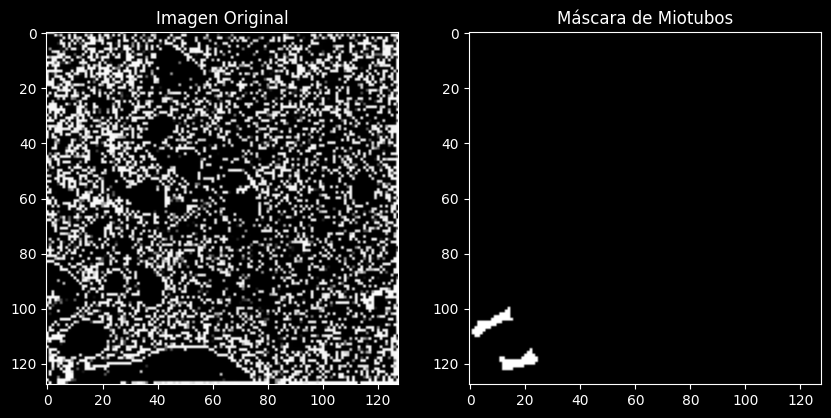

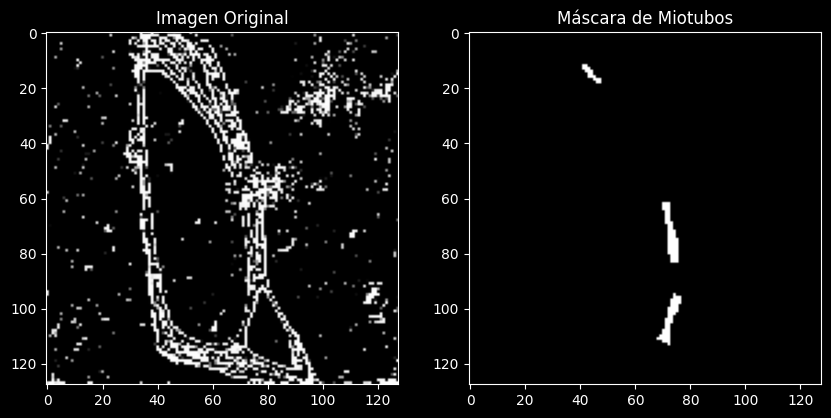

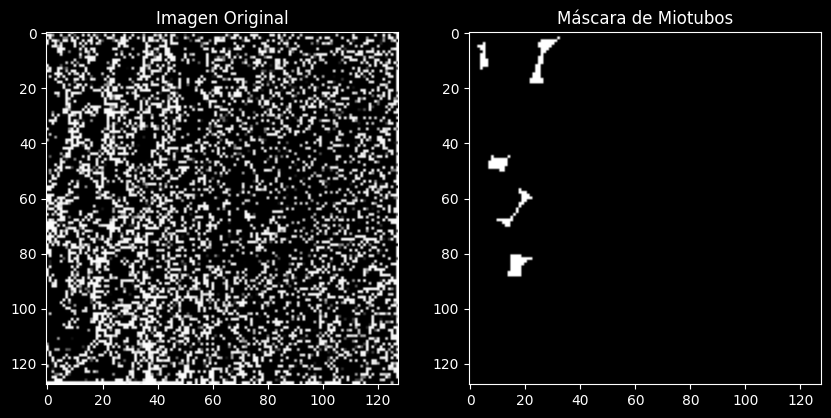

In [6]:
imagenes = np.array(imagenes)
mascaras = np.array(mascaras)

# DIVIMOS LOS DATOS EN ENTRENAMIENTO Y VALIDACION (80 - 20)
X_train, X_val, y_train, y_val = train_test_split(imagenes, mascaras, test_size=0.2, random_state=42, shuffle=True)

# VISUALIZAMOS IMAGENES Y SUS MASCARAS
for i in range(3):
    muestraImgMask(X_train, y_train, i)

Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - accuracy: 0.9123 - loss: 0.7605 - val_accuracy: 0.9690 - val_loss: 0.4539
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.9766 - loss: 0.3848 - val_accuracy: 0.9690 - val_loss: 0.4389
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.9749 - loss: 0.3865 - val_accuracy: 0.9690 - val_loss: 0.3577
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.9767 - loss: 0.3234 - val_accuracy: 0.9690 - val_loss: 0.3294
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.9763 - loss: 0.2822 - val_accuracy: 0.9690 - val_loss: 0.3076
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.9776 - loss: 0.2708 - val_accuracy: 0.9690 - val_loss: 0.2838
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.9761 - loss: 0.2542 - val_accuracy: 0.9690 - val_loss: 0.2789
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.9766 - loss: 0.2370 - val_accuracy: 0.9690 - v

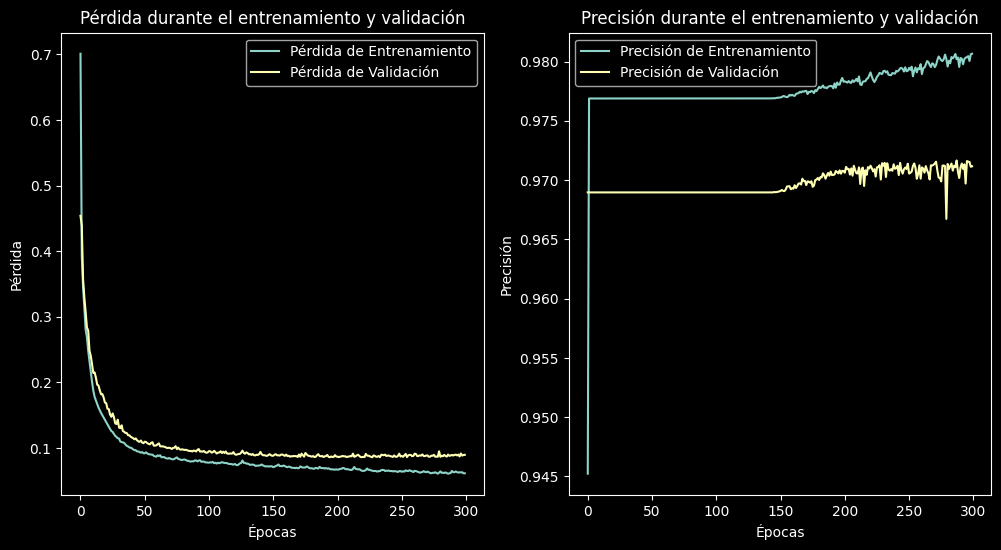

In [8]:
# CREAMOS EL MODELO DE SEGMENTACION
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same'),
    Conv2D(1, (1, 1), activation='sigmoid')
])

# COMPILAMOS EL MODELO
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# AGREGAMOS UNA DIMENSION PARA ENTRENAMIENTO
image = np.expand_dims(image, axis=0)
mask = np.expand_dims(mask, axis=0)

# ENTRENAMOS EL MODELO CON 500 EPOCAS
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val))

# MOSTRAMOS LAS METRICAS
plt.figure(figsize=(12, 6))

# GRAFICA DE PERDIDA
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# GRAFICA DE PRECISION
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 999,365 (3.81 MB)

 Trainable params: 333,121 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 666,244 (2.54 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


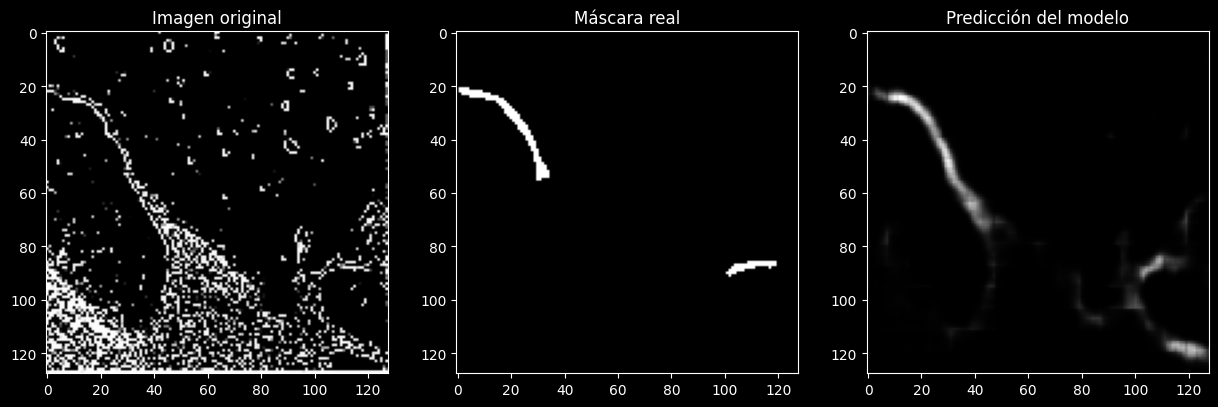

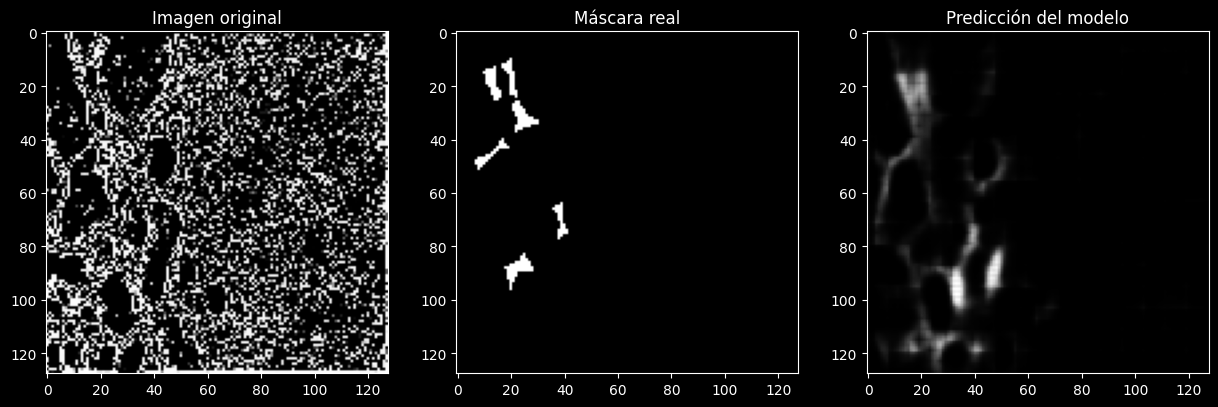

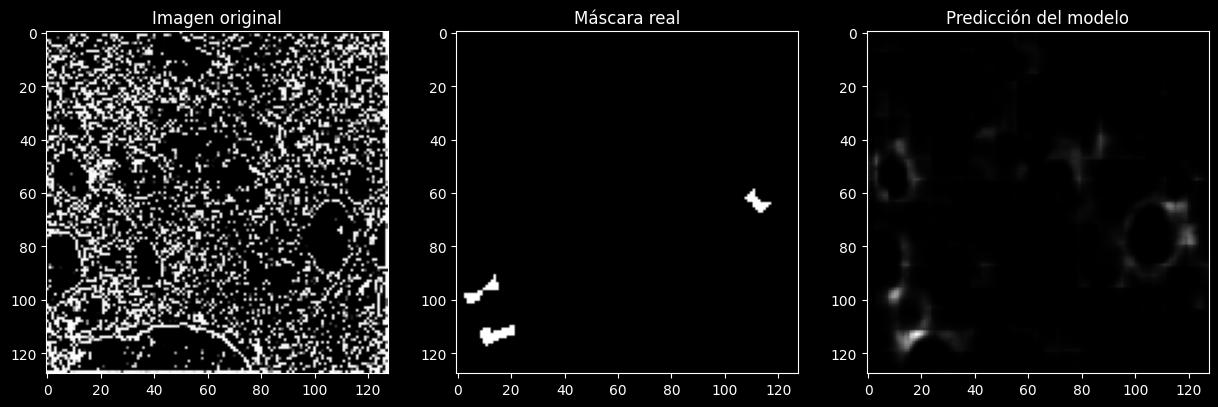

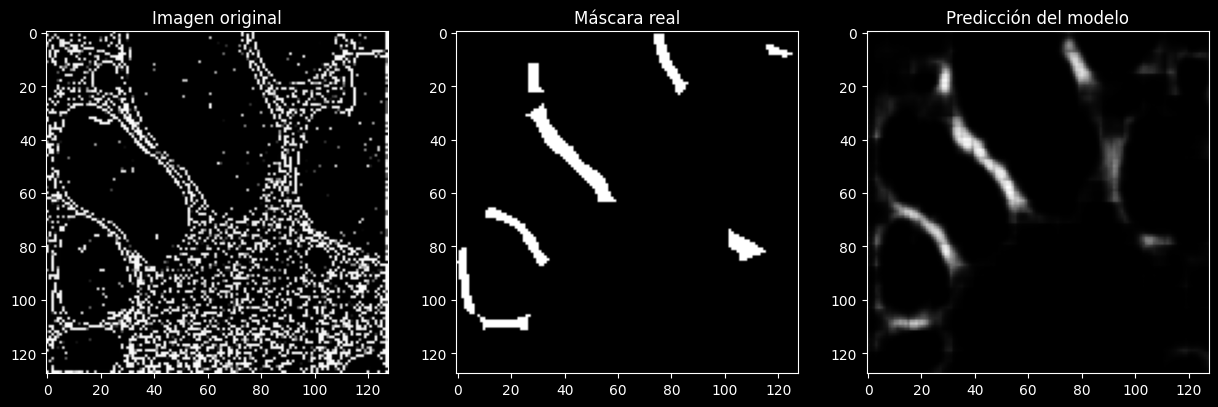

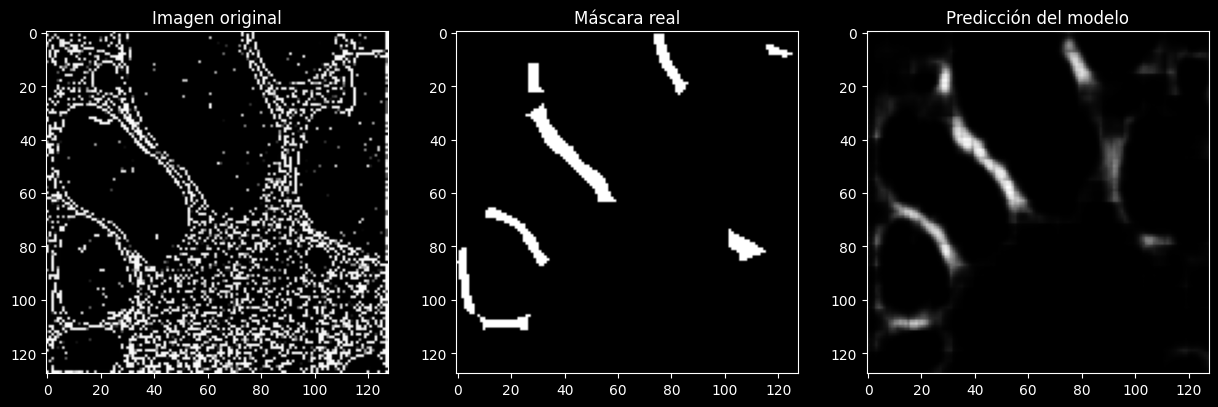

In [10]:
# PREDECIMOS LAS MASCARAS PARA EL CONJUNTO DE VALIDACION
predicciones = model.predict(X_val)

# MOSTRAMOS UNA IMAGEN, LA MASCARA REAL Y LA PREDICCION
def muestraRealvsPred(index):
    plt.figure(figsize=(15, 5))

    # IMAGEN ORIGINAL
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Imagen original")
    
    # MASCARA REAL
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[index].squeeze(), cmap='gray')
    plt.title("Máscara real")
    
    # MASCARA PREDICHA
    plt.subplot(1, 3, 3)
    plt.imshow(predicciones[index].squeeze(), cmap='gray')
    plt.title("Predicción del modelo")
    
    plt.show()

# MOSTRAMOS ALGUNOS EJEMPLOS
for i in range(5):
    img_random = np.random.randint(0, len(predicciones)-1)
    muestraRealvsPred(img_random)

# Intento 5

C:\Users\aless\AppData\Local\Temp\ipykernel_14204\4015749620.py:38: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


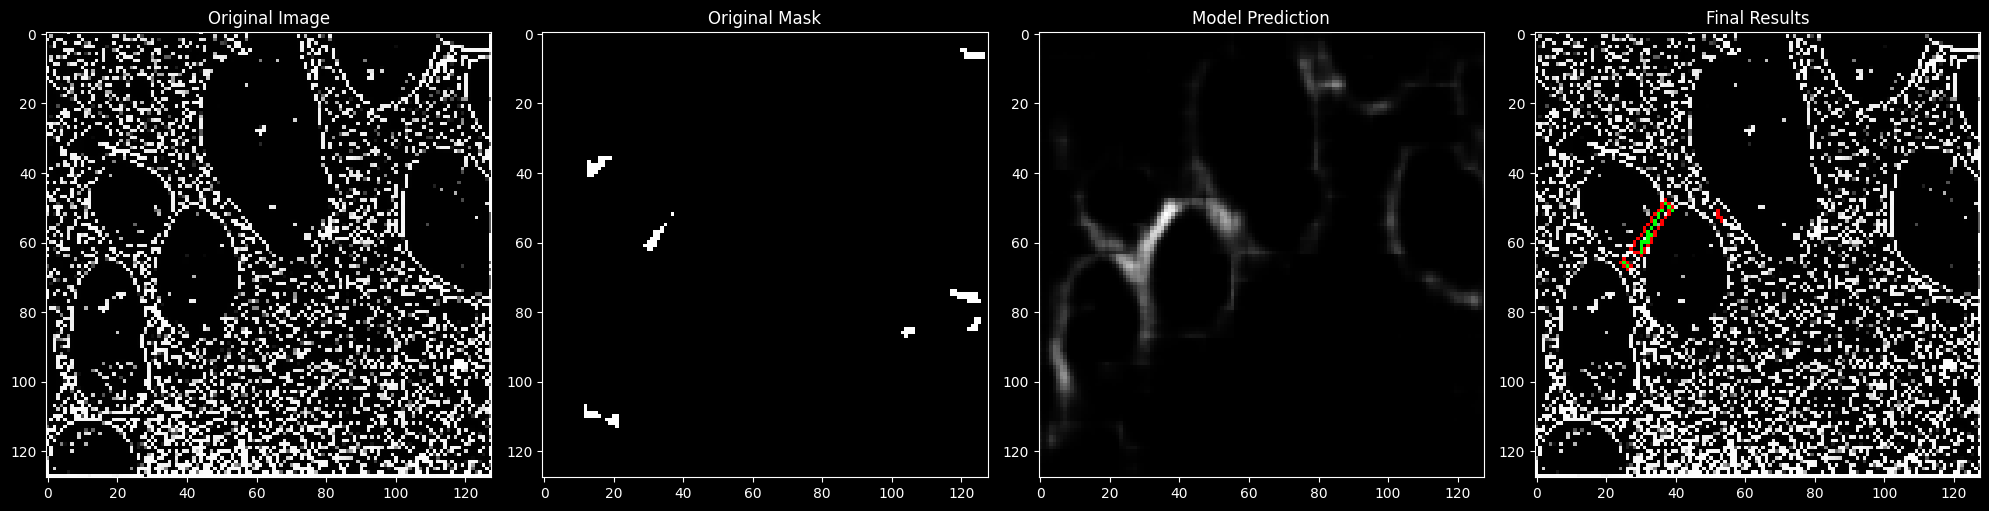

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


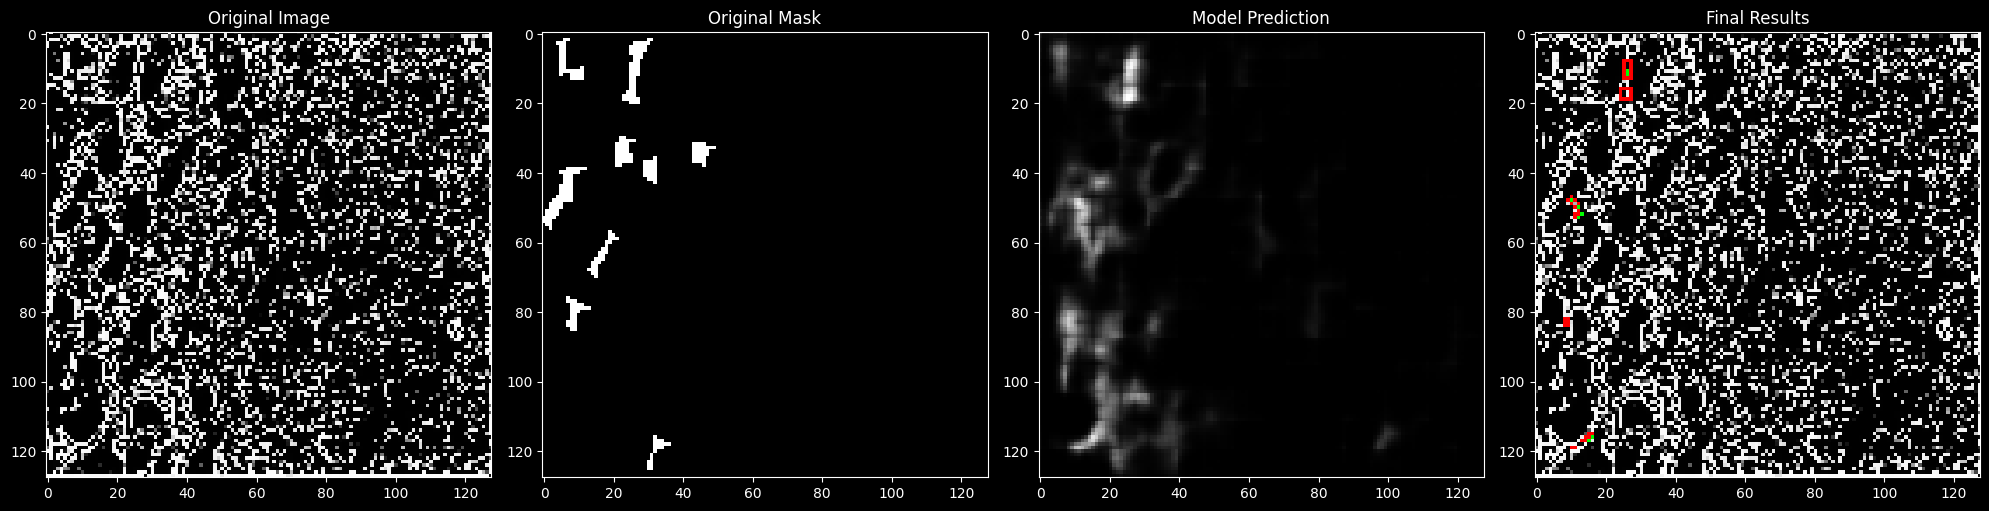

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


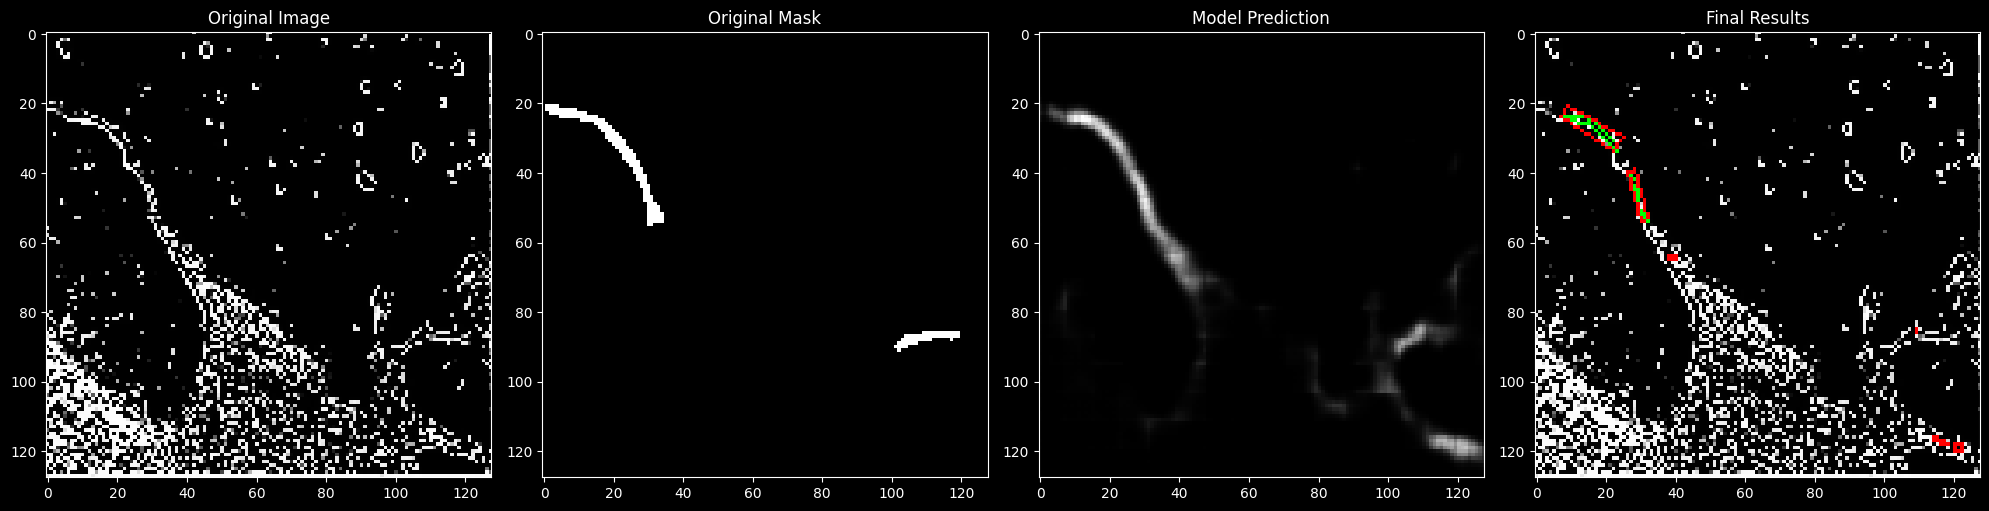

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


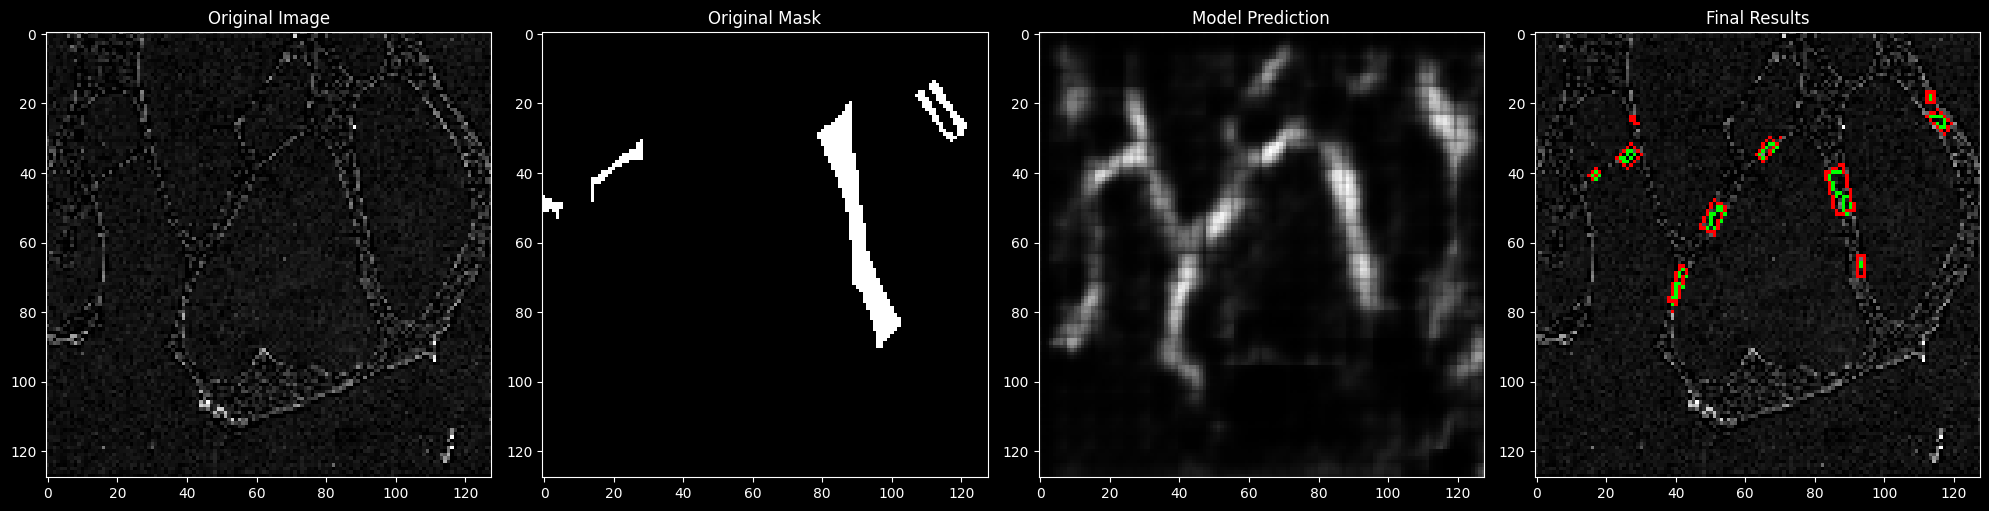

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


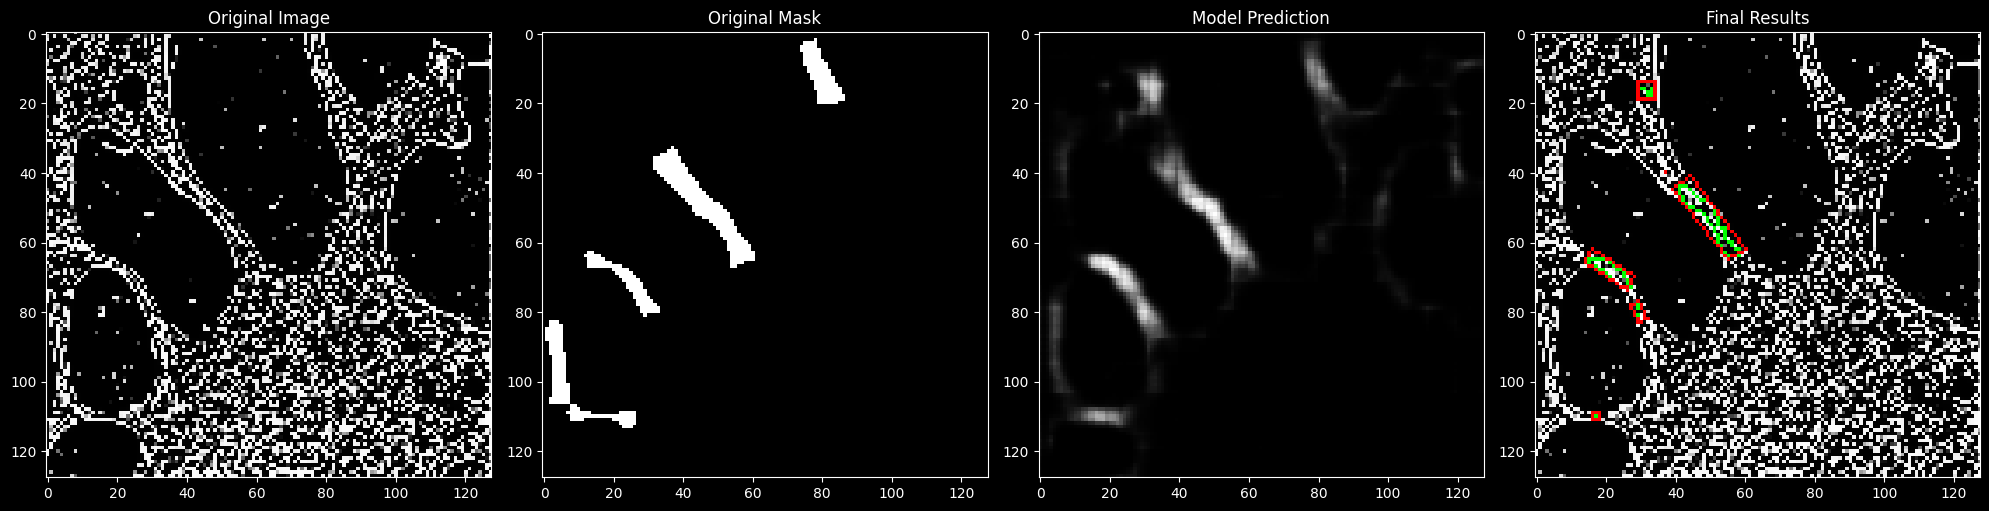

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


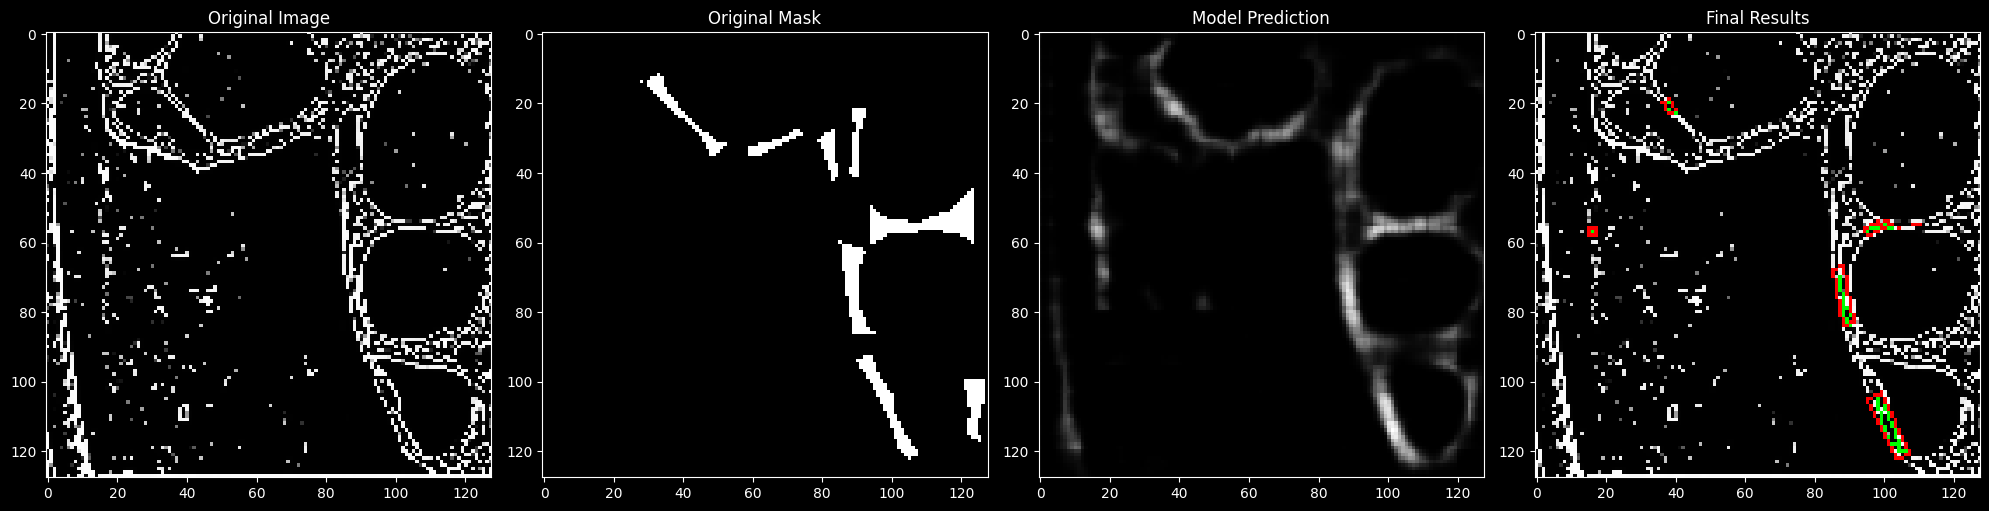

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


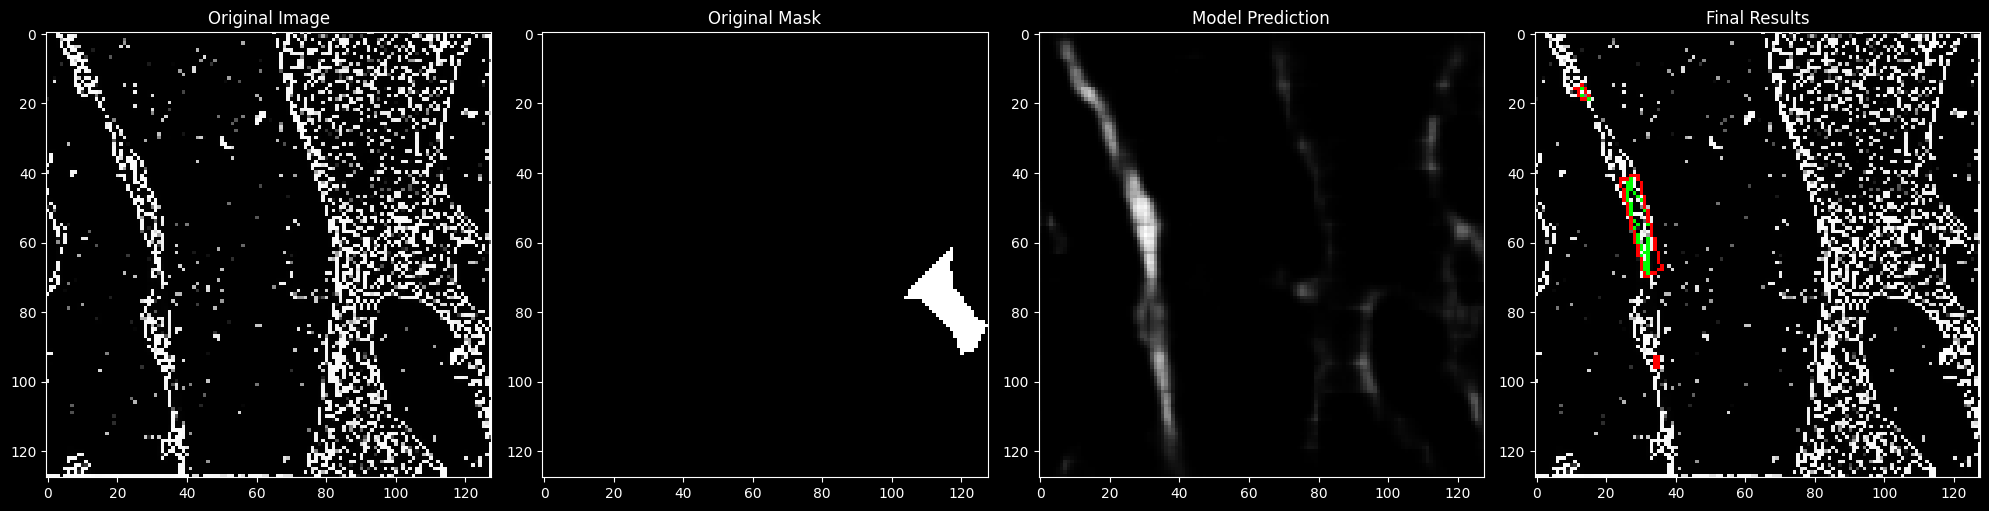

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


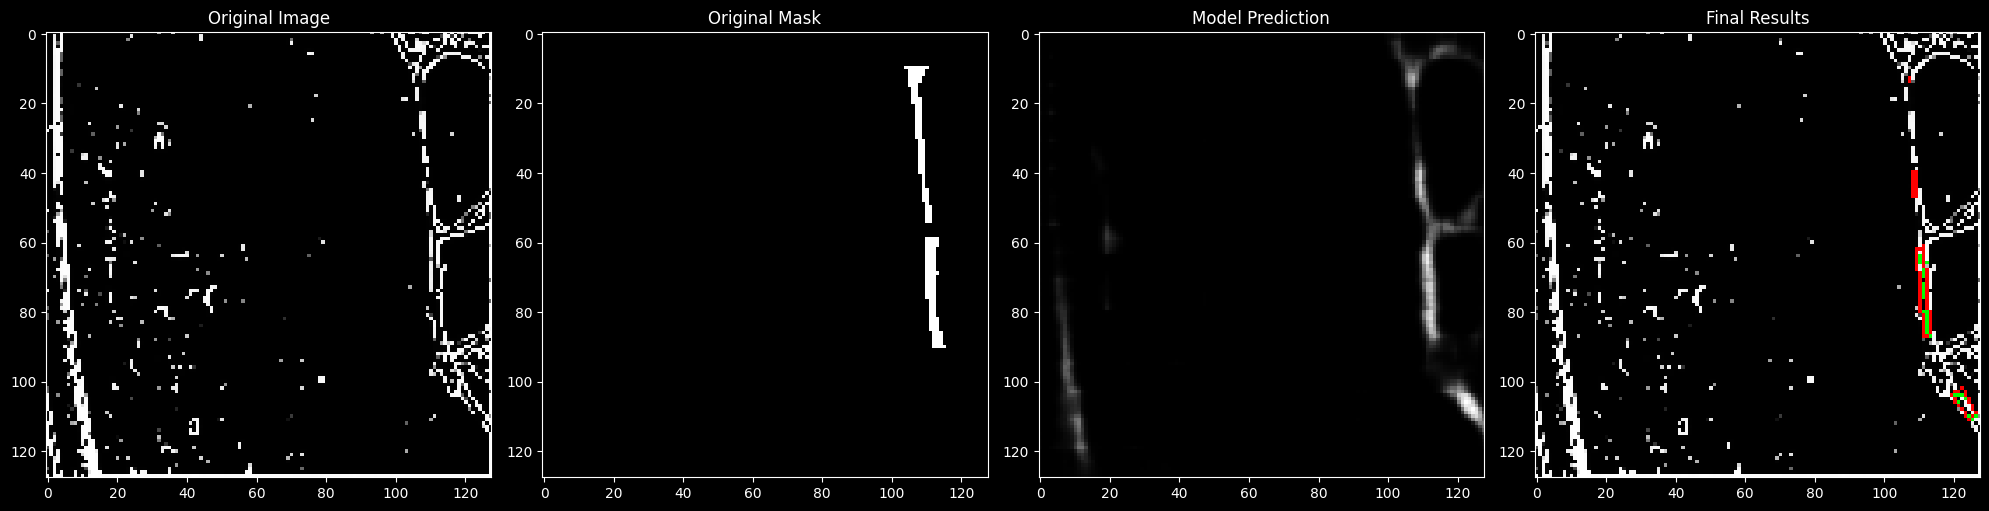

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


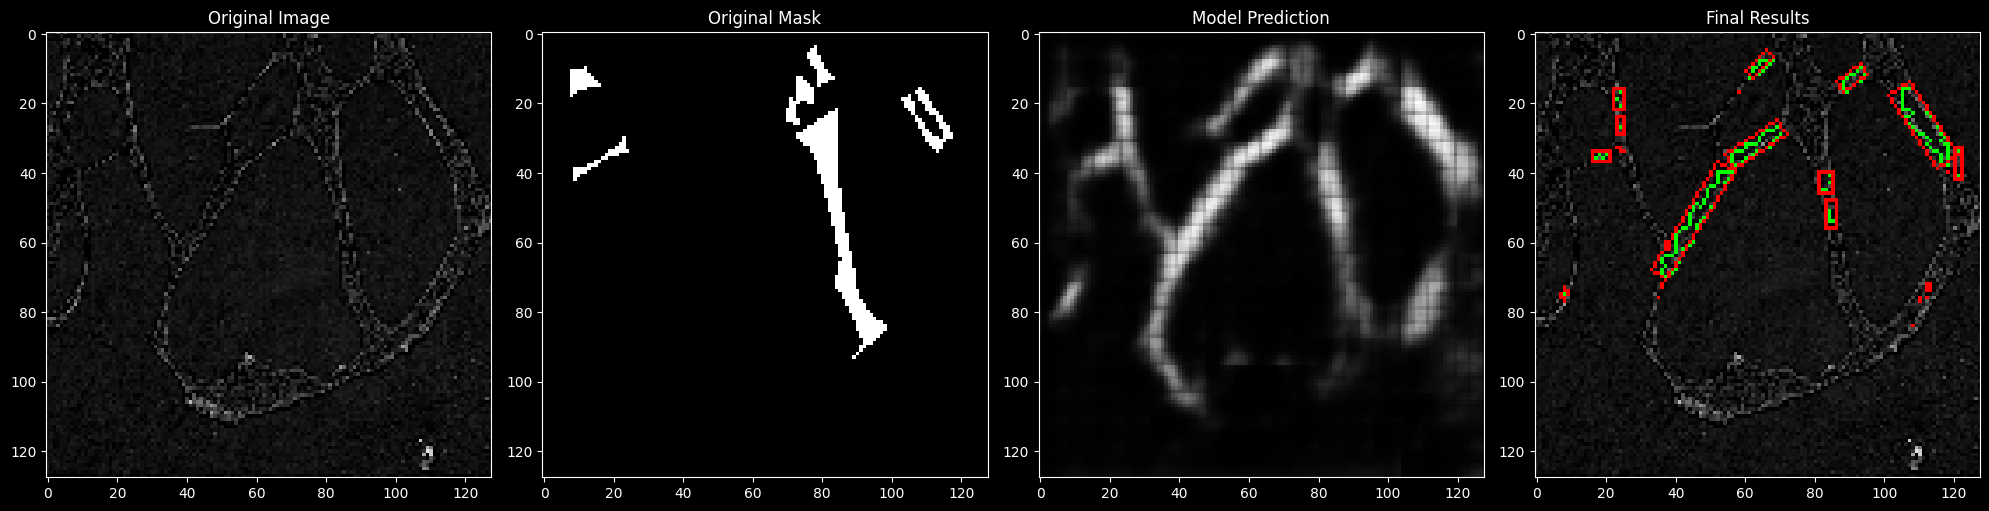

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


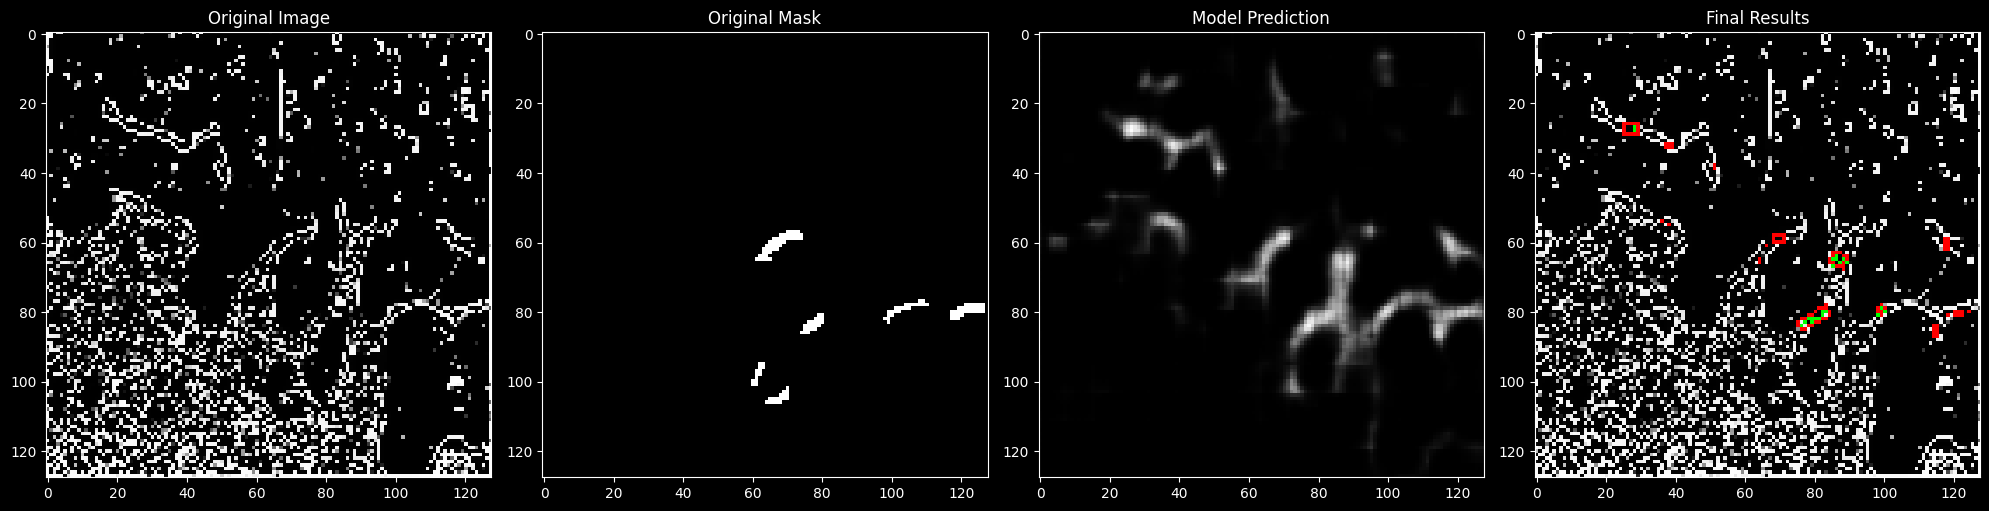

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


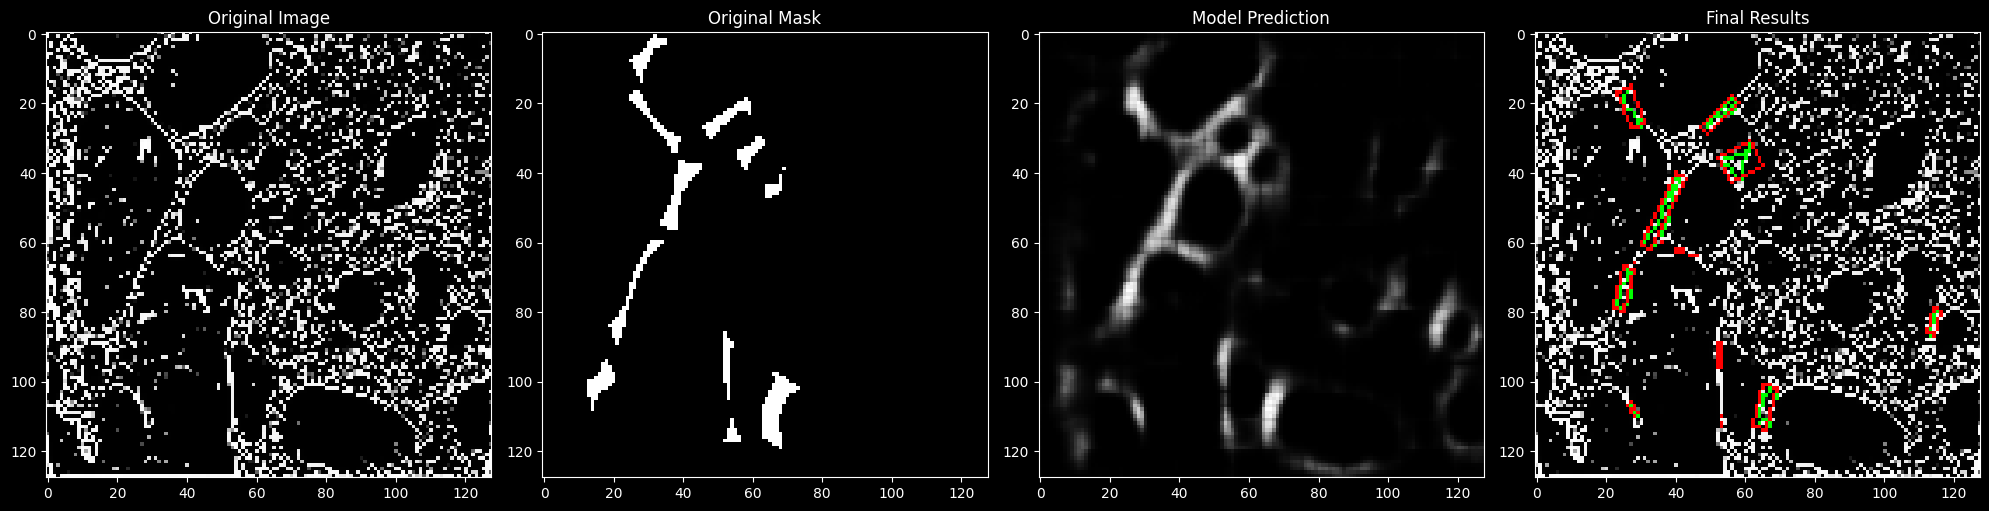

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


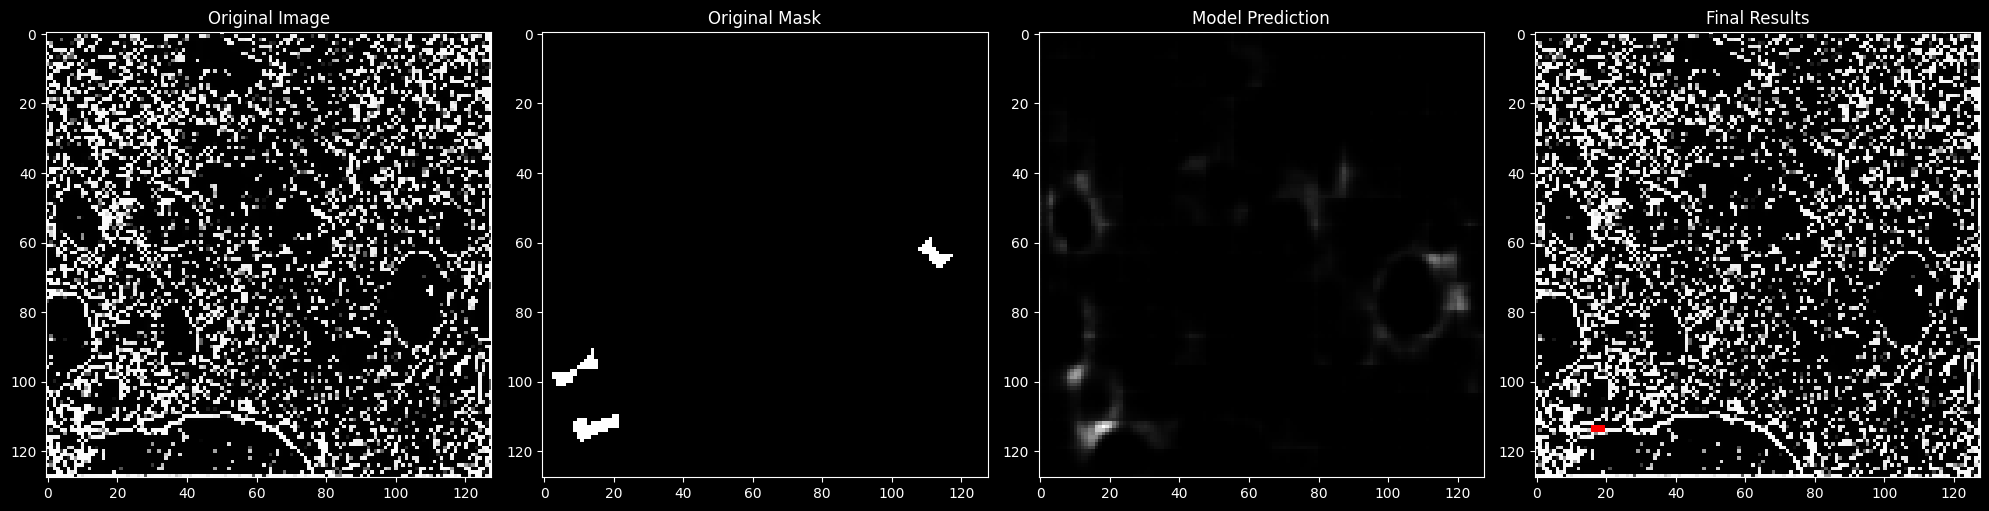

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


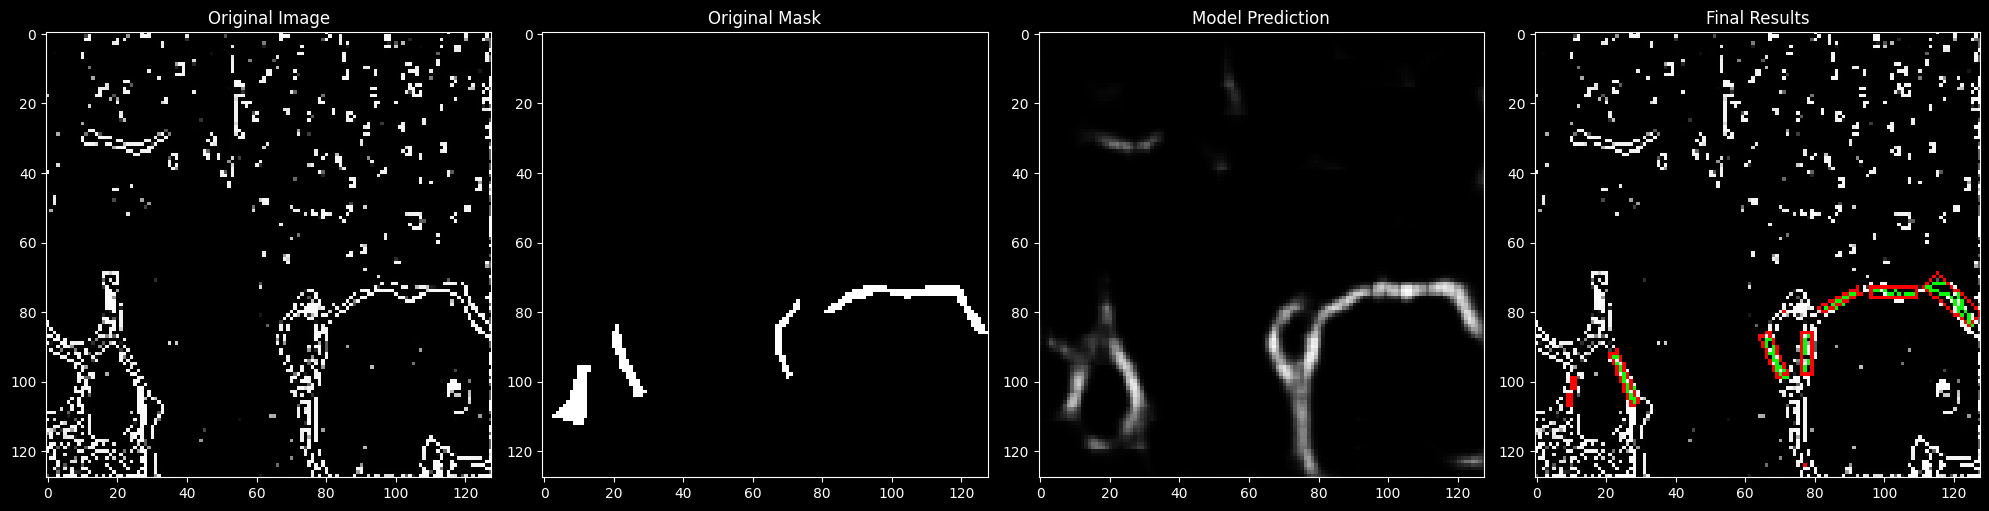

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


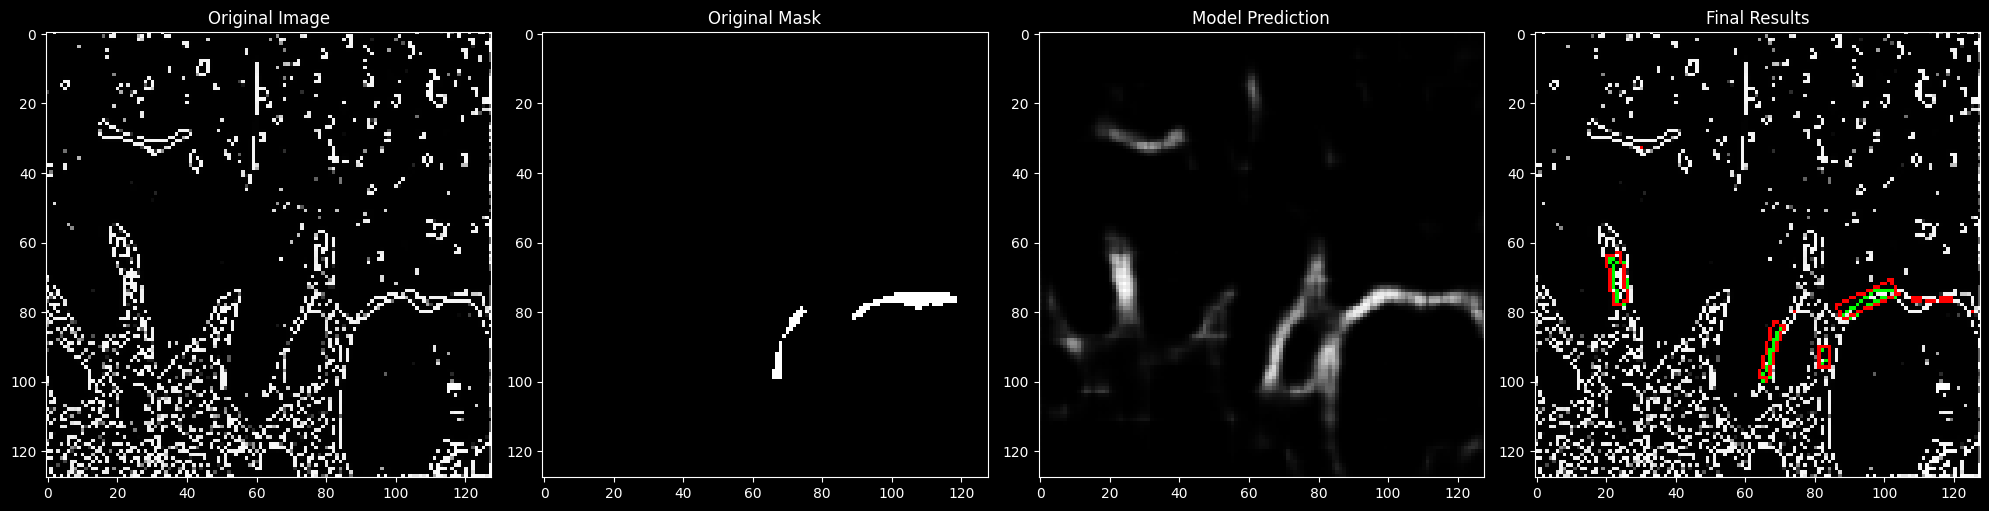

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


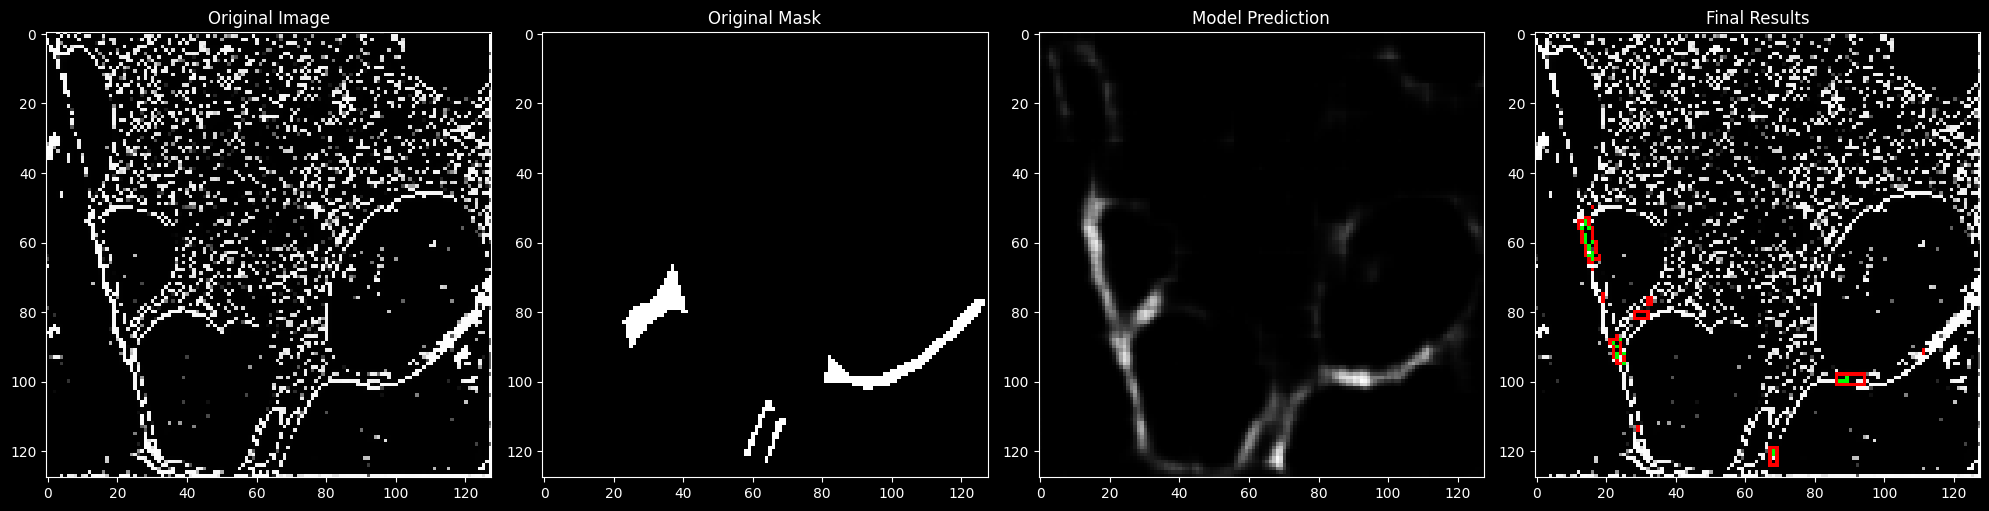

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


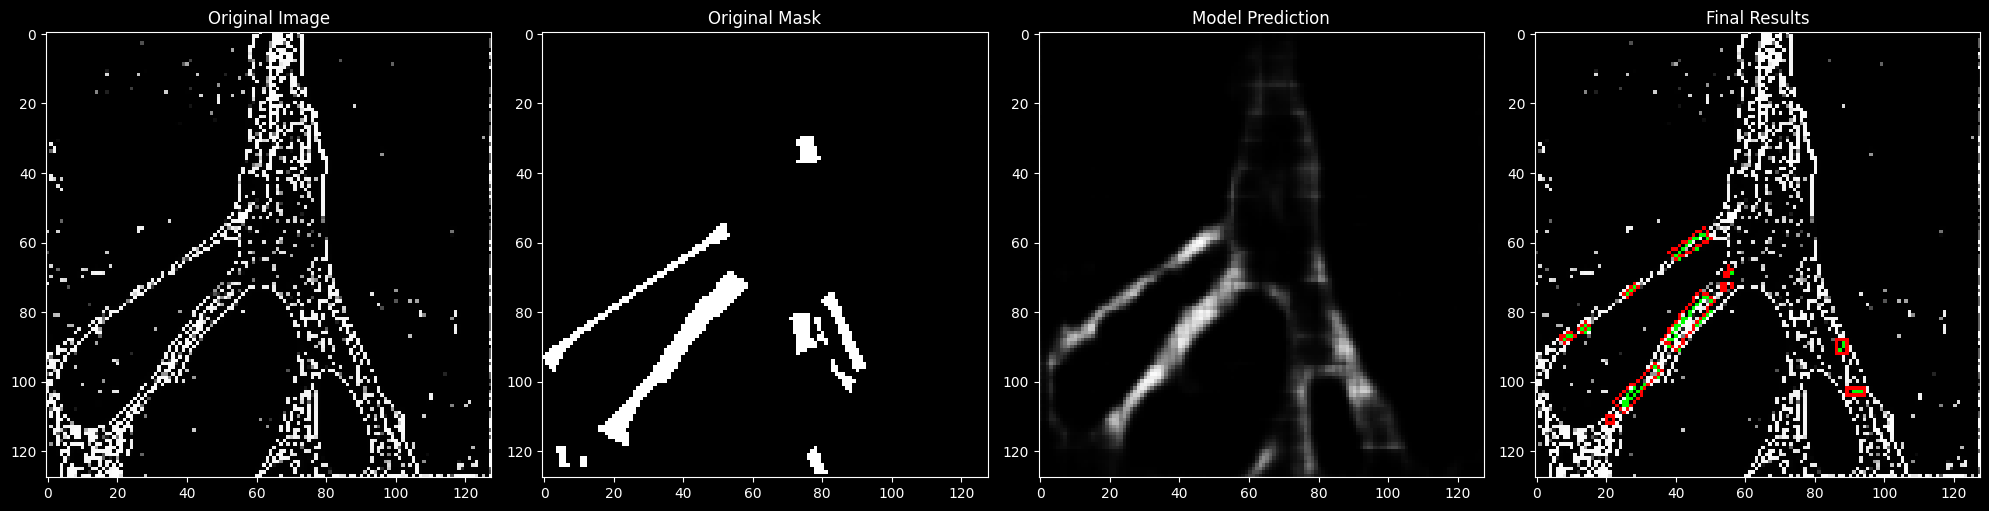

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


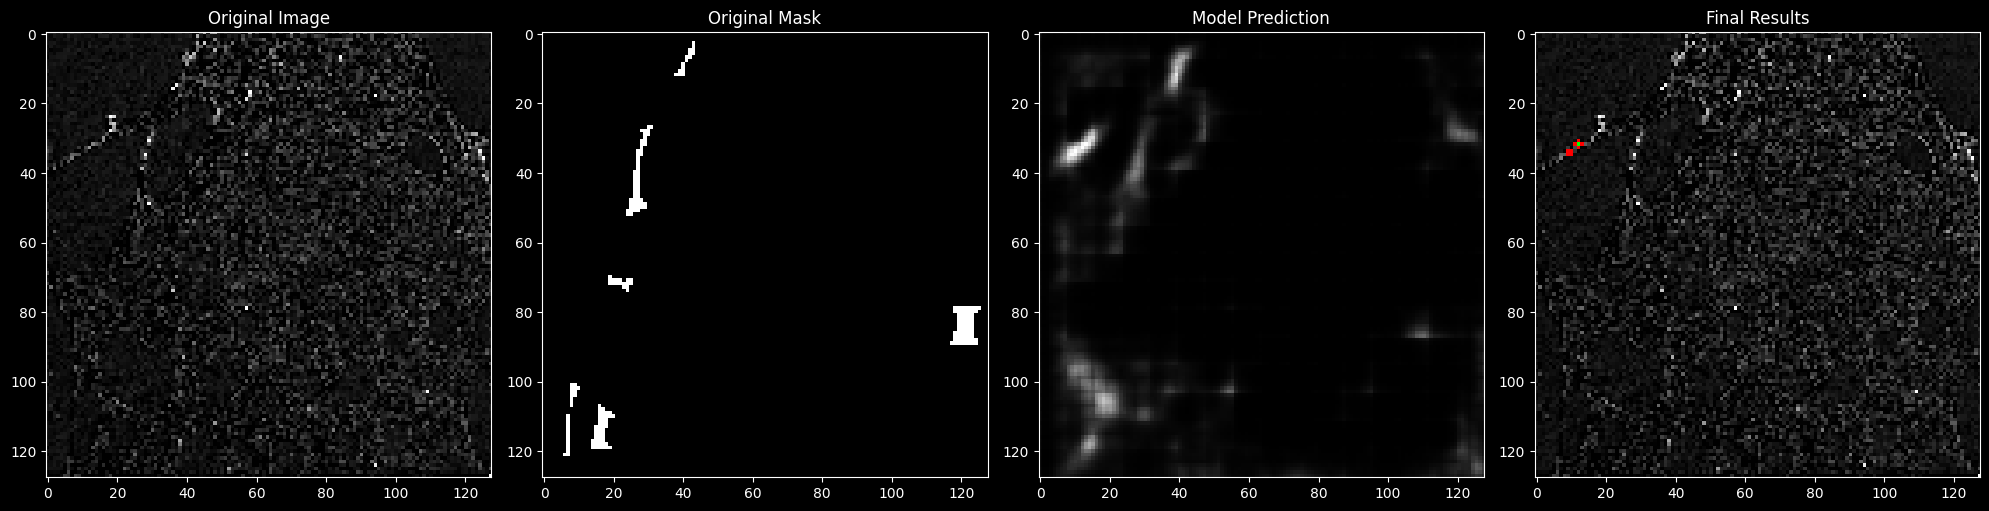

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


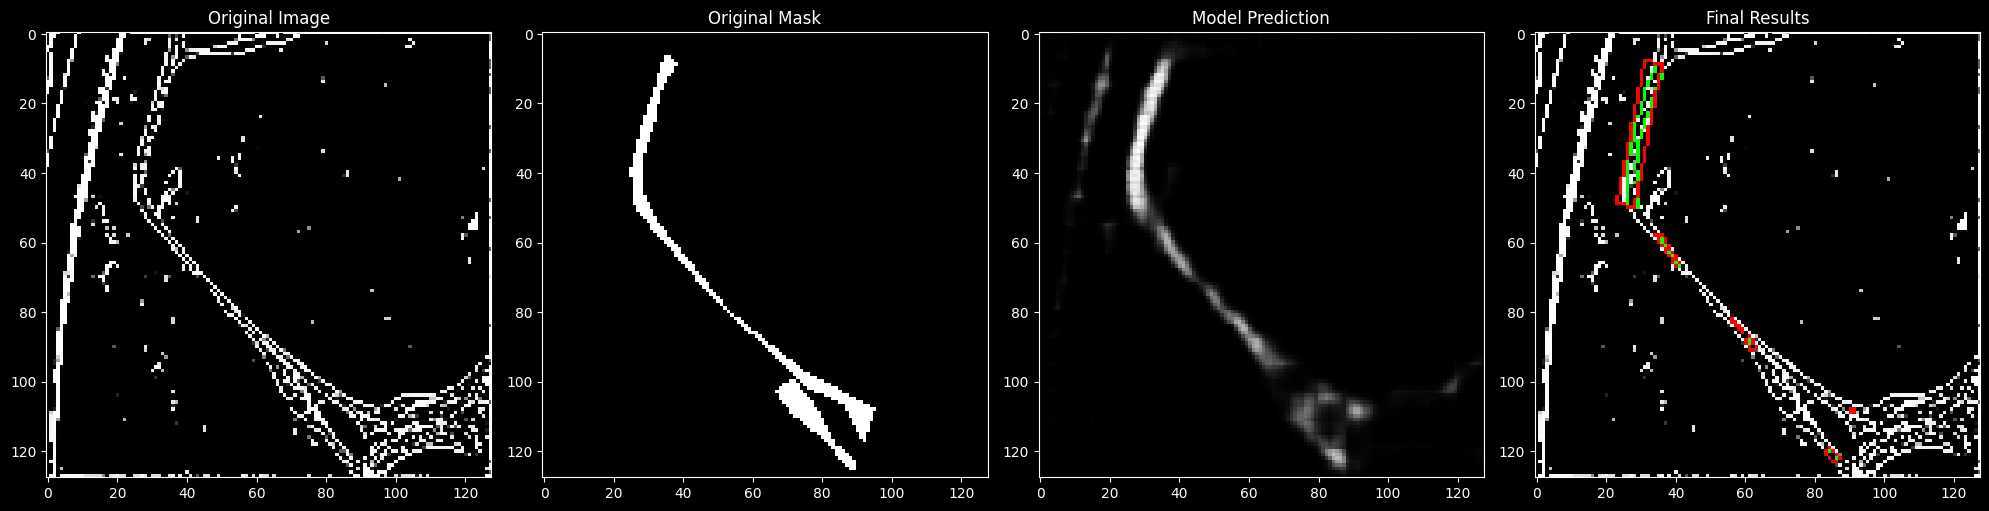

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


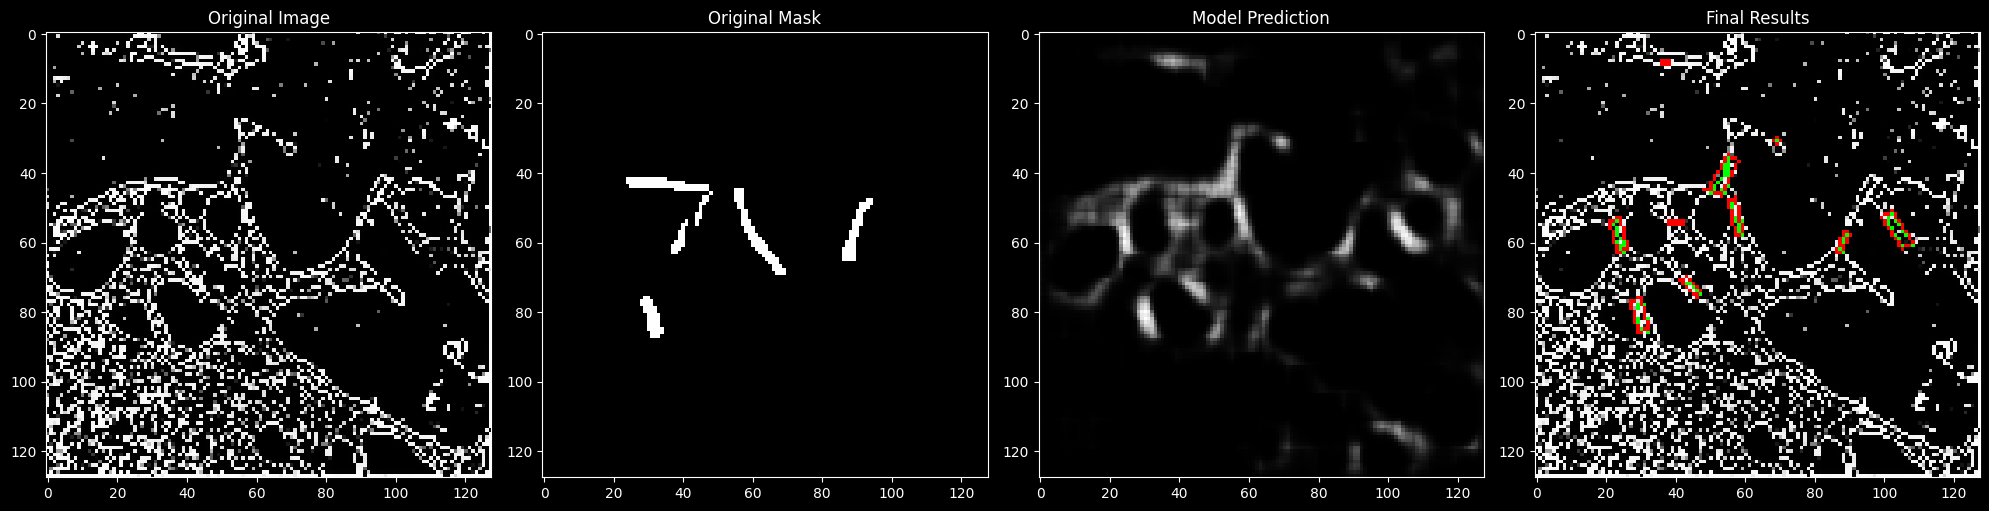

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


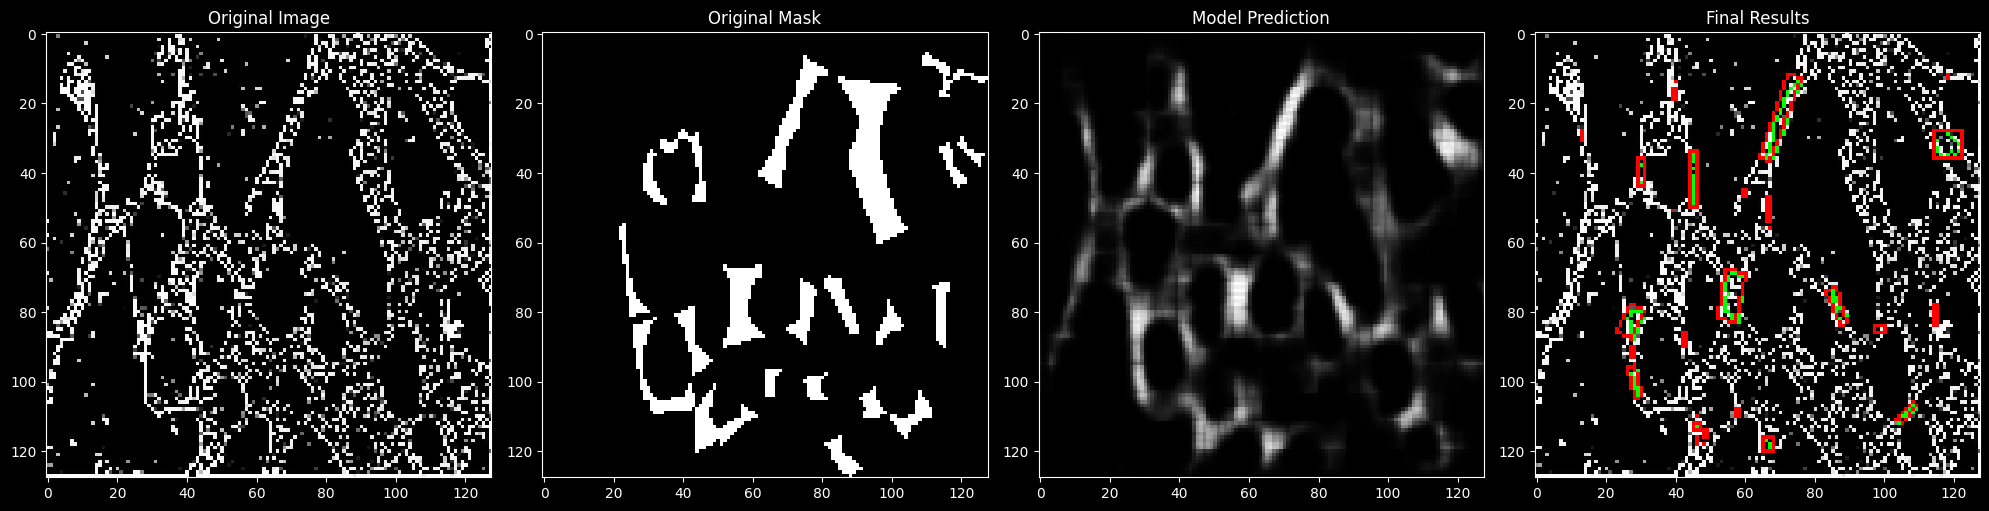

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


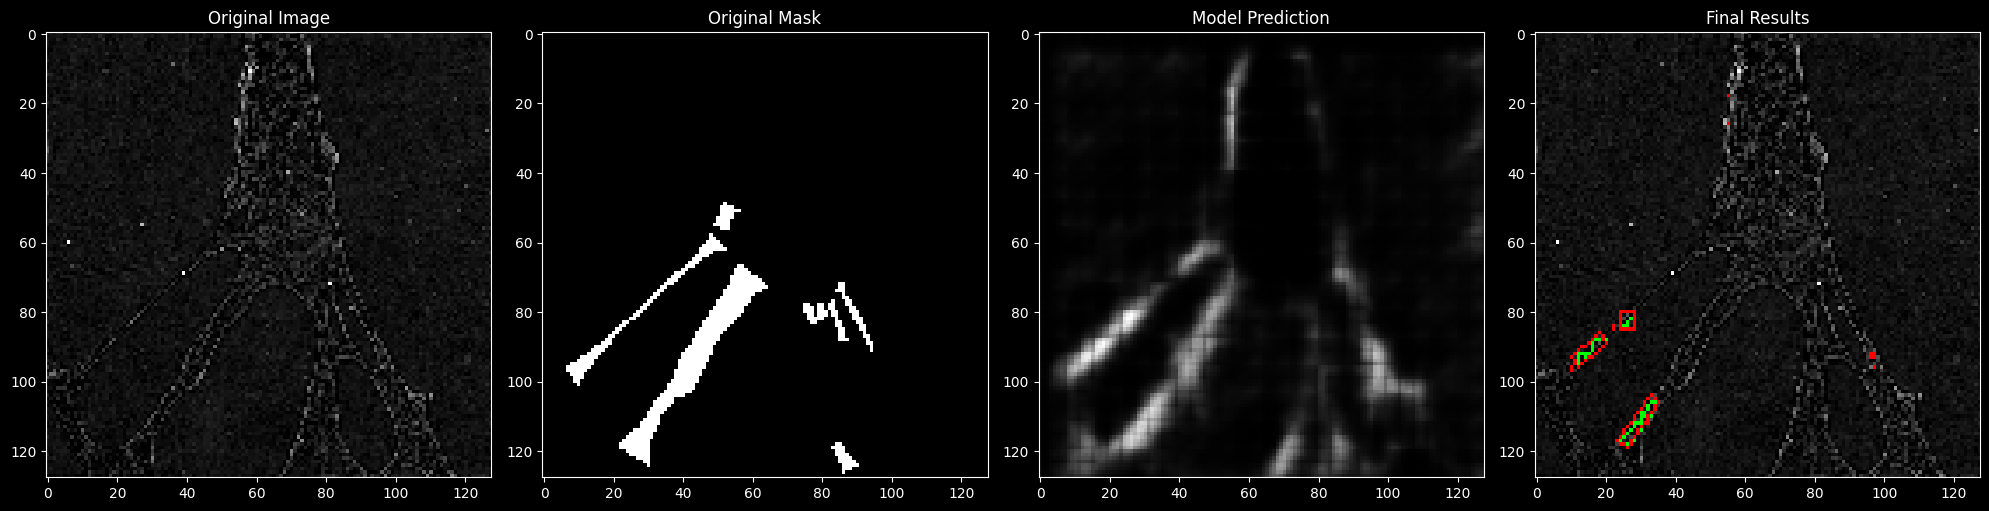

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


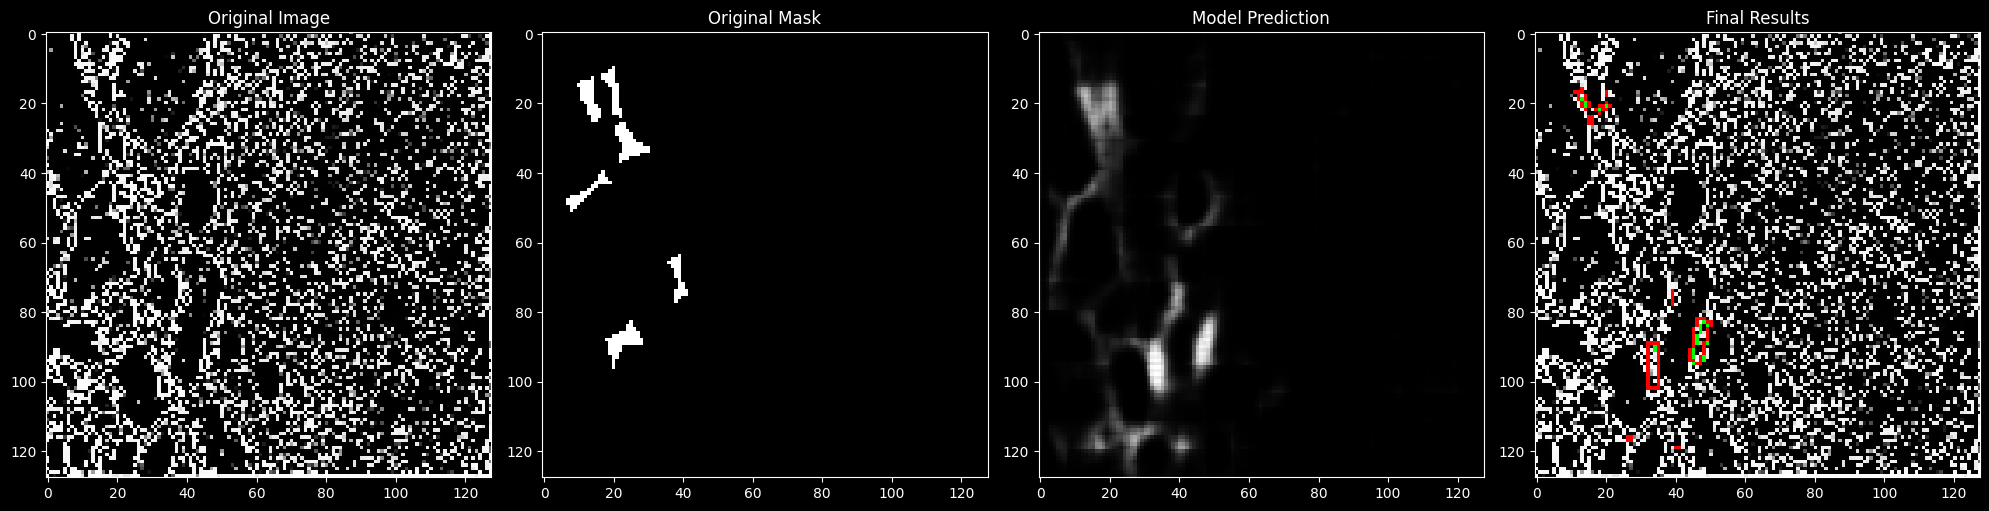

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


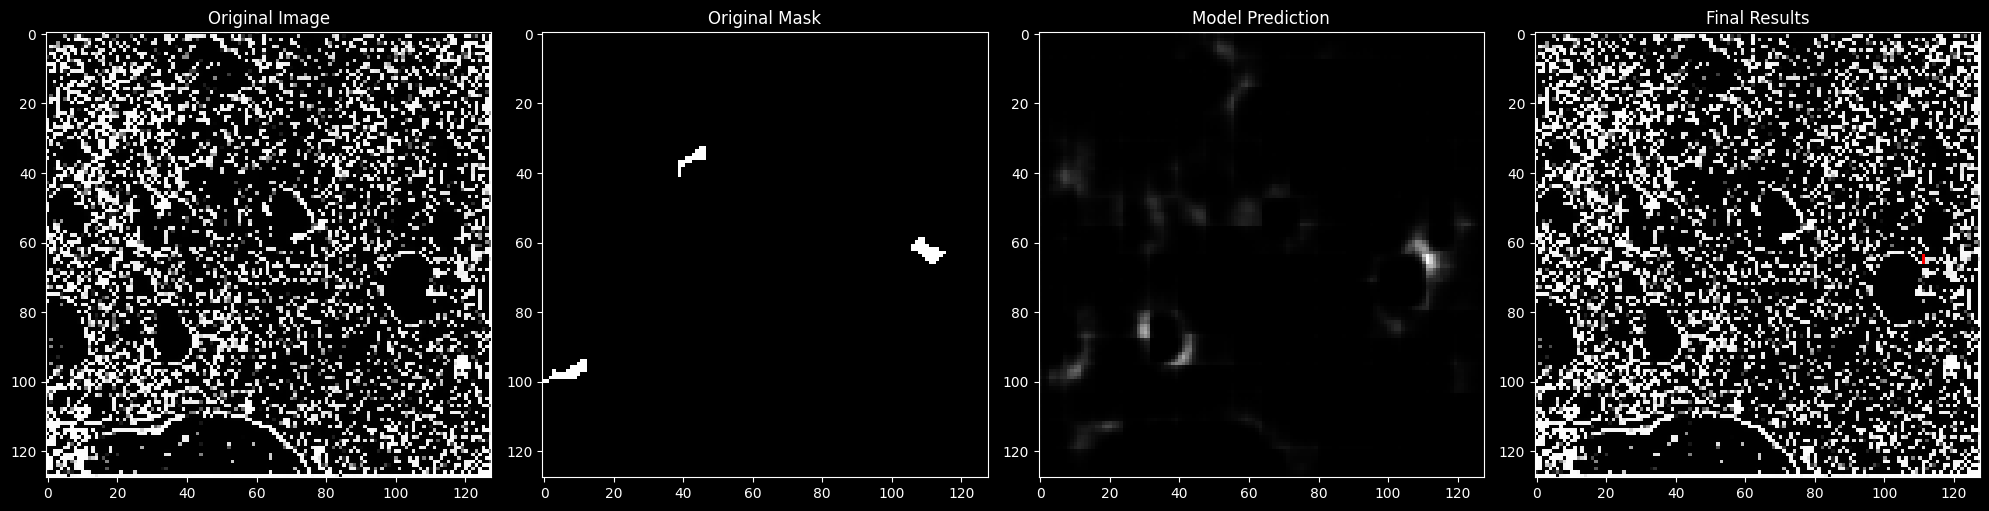

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


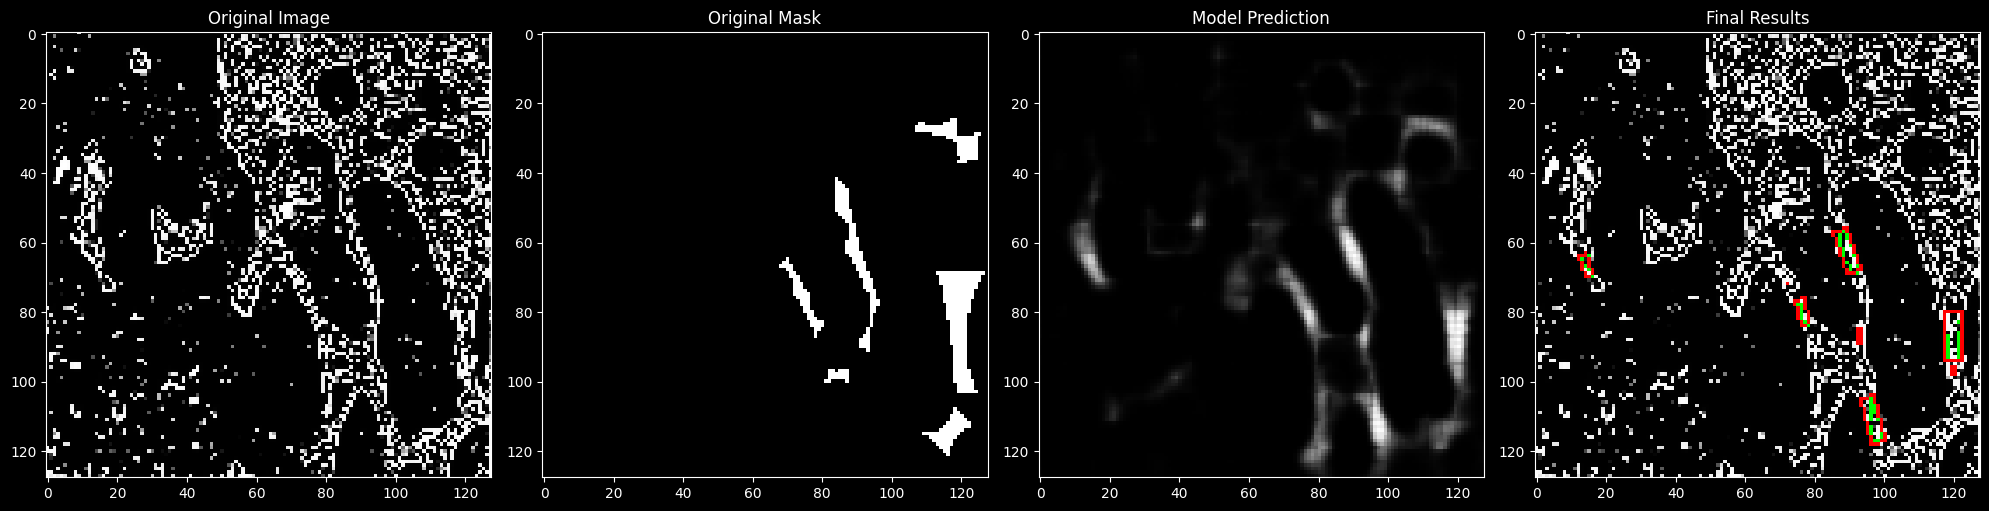

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


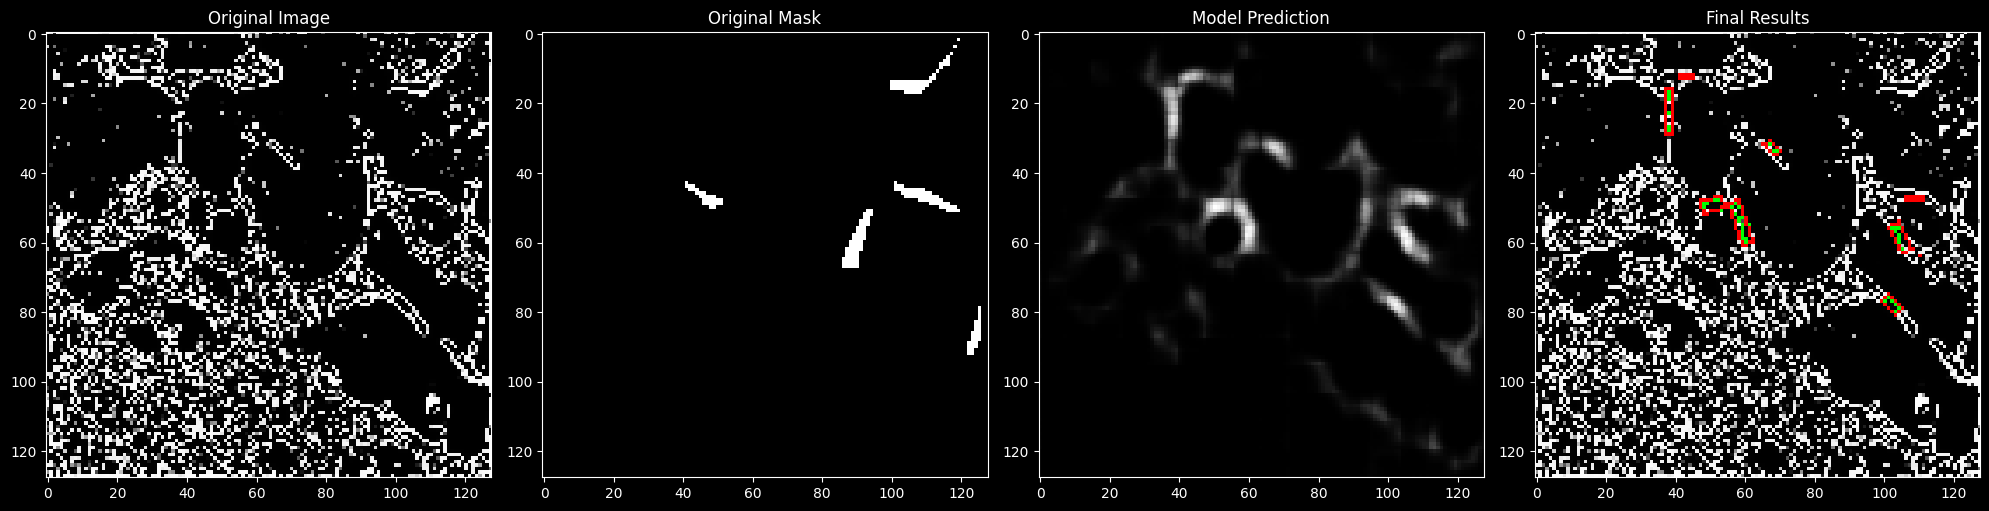

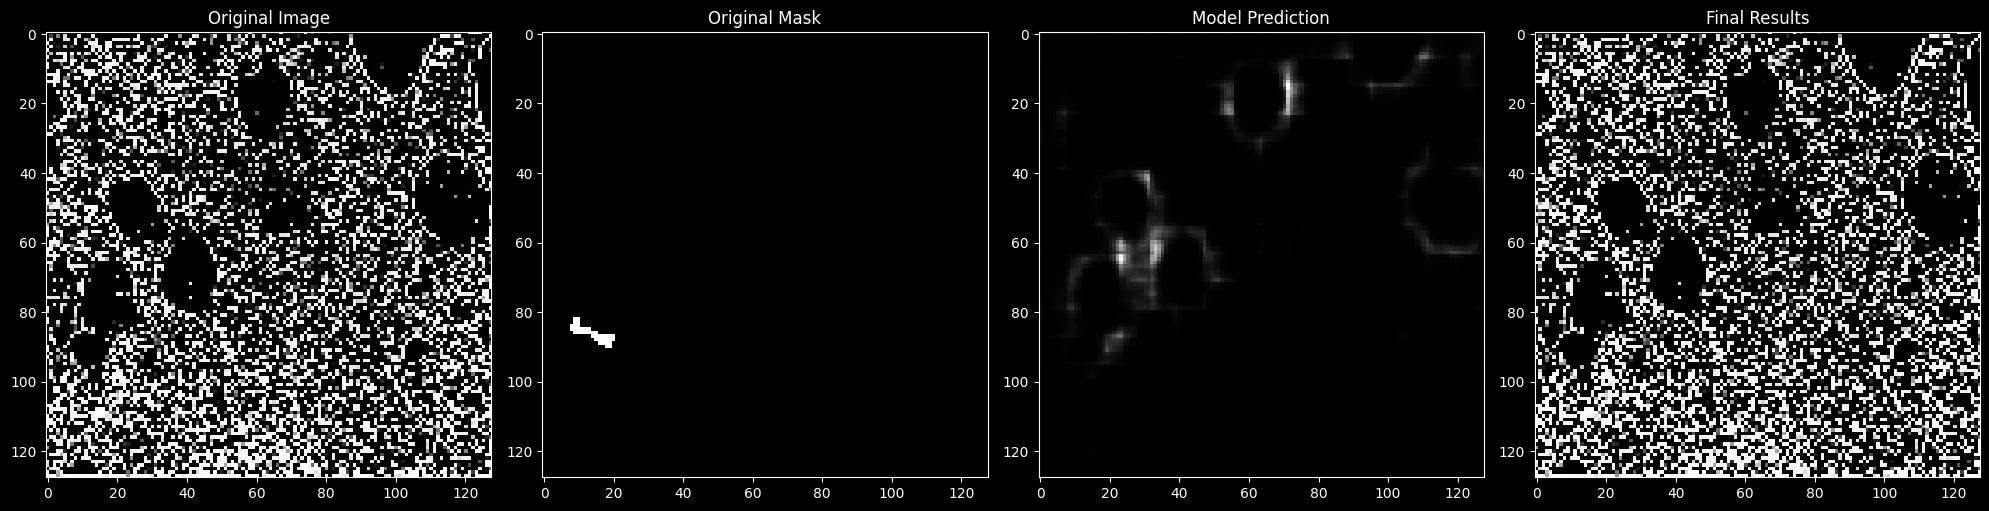

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


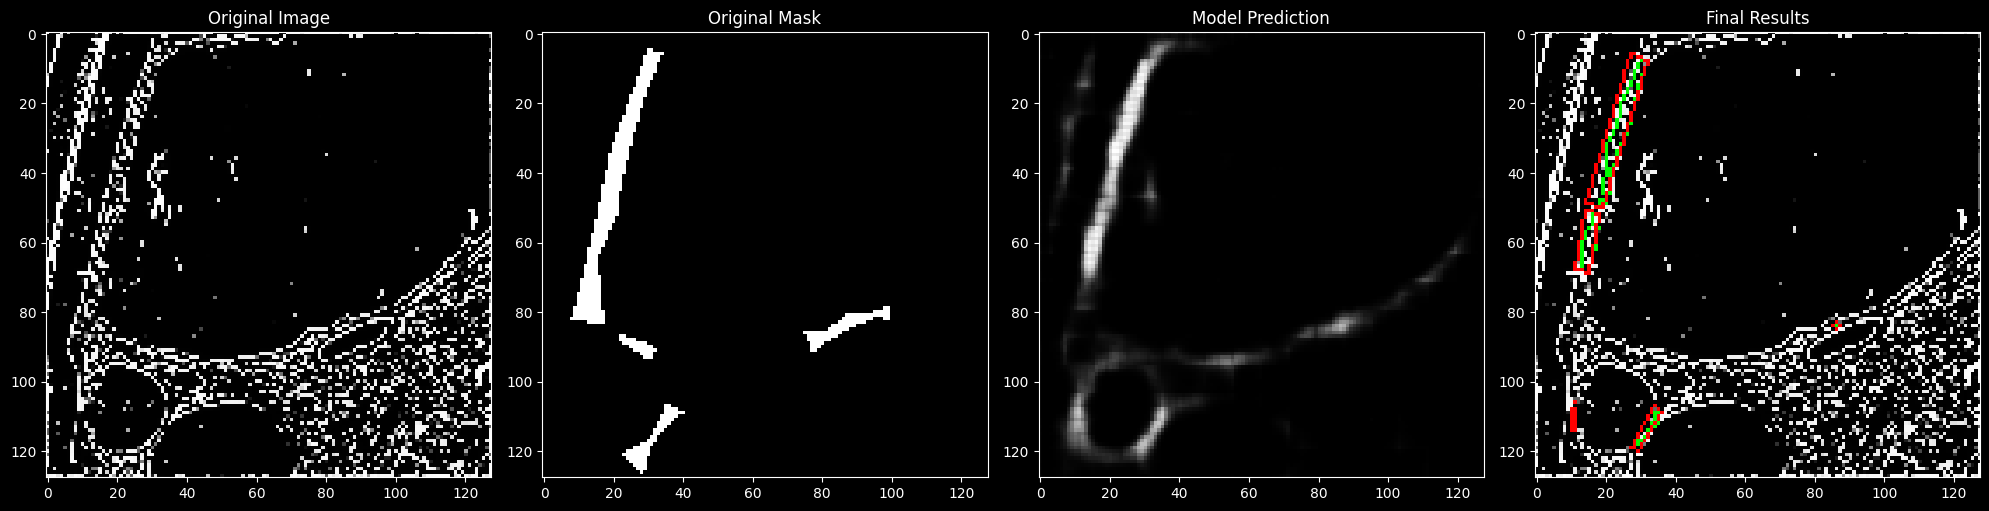

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


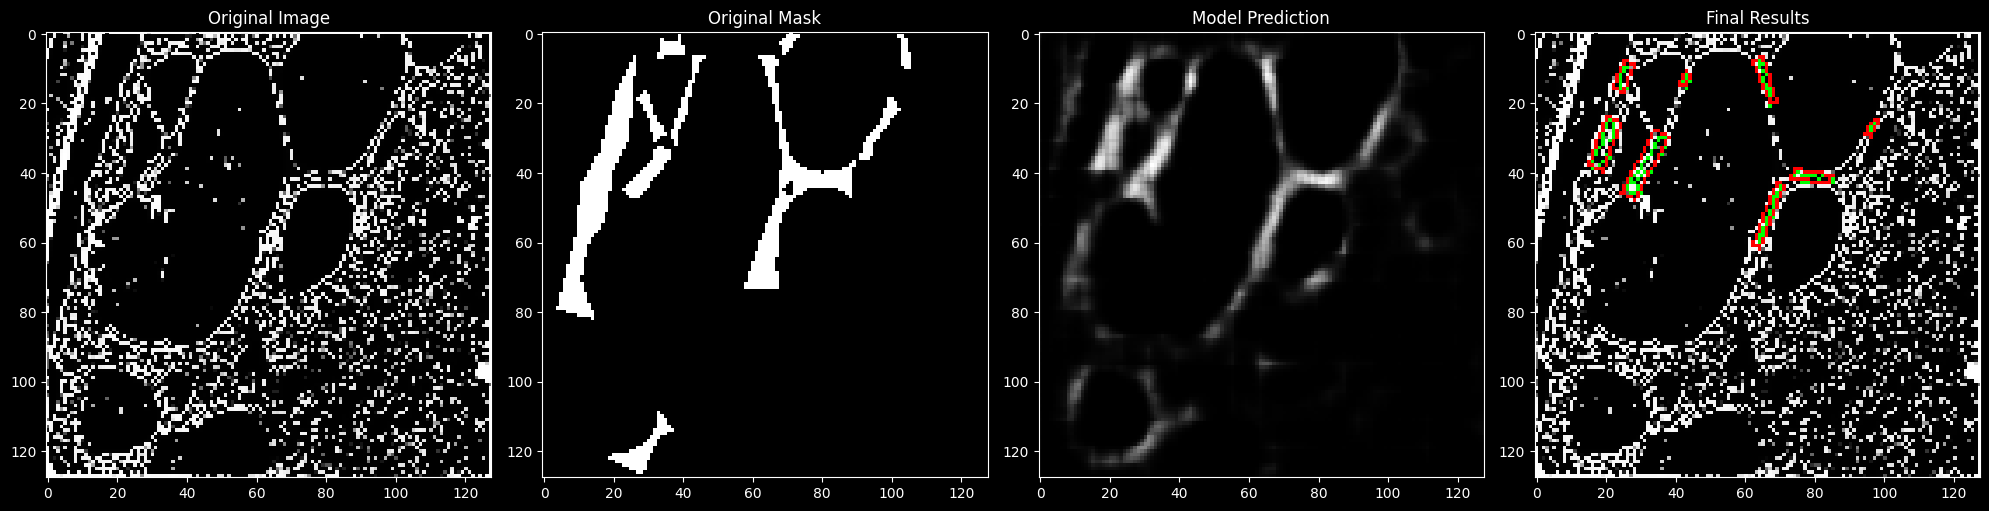

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


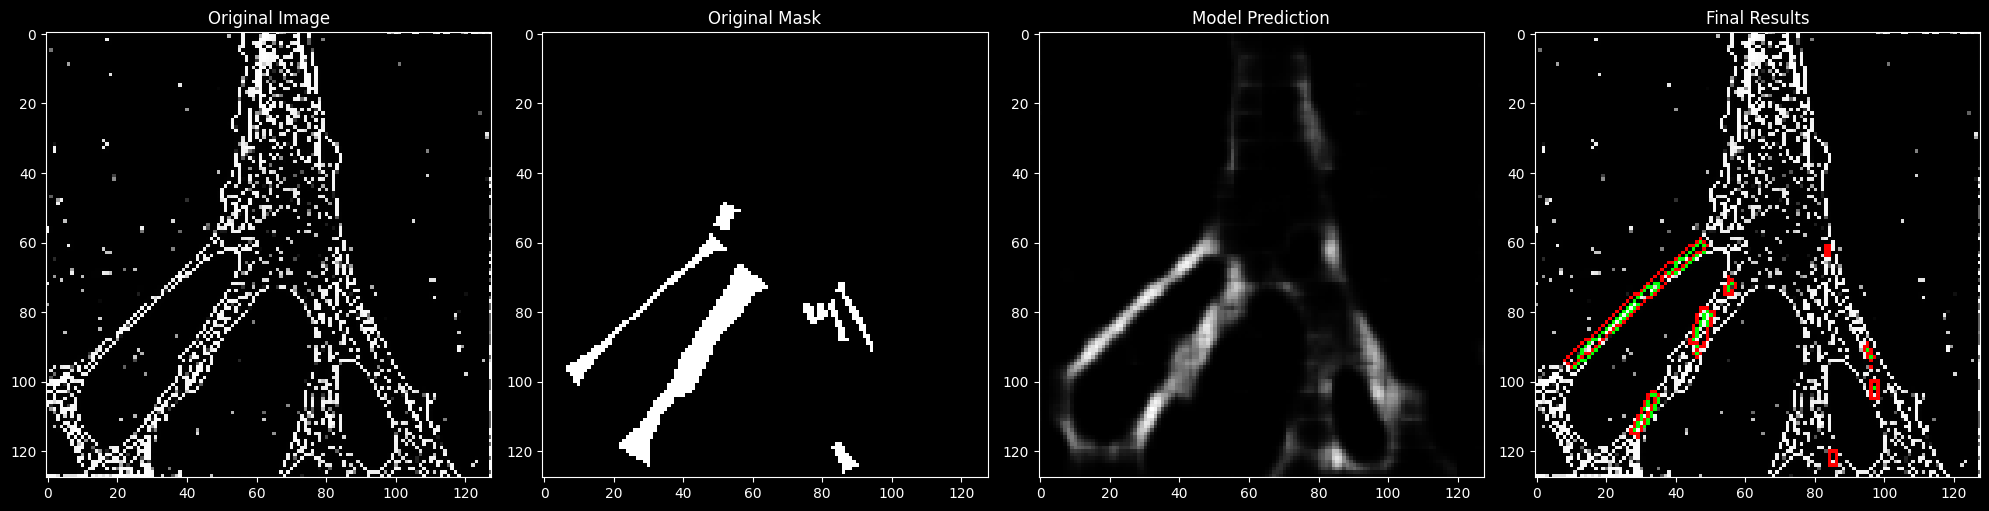

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


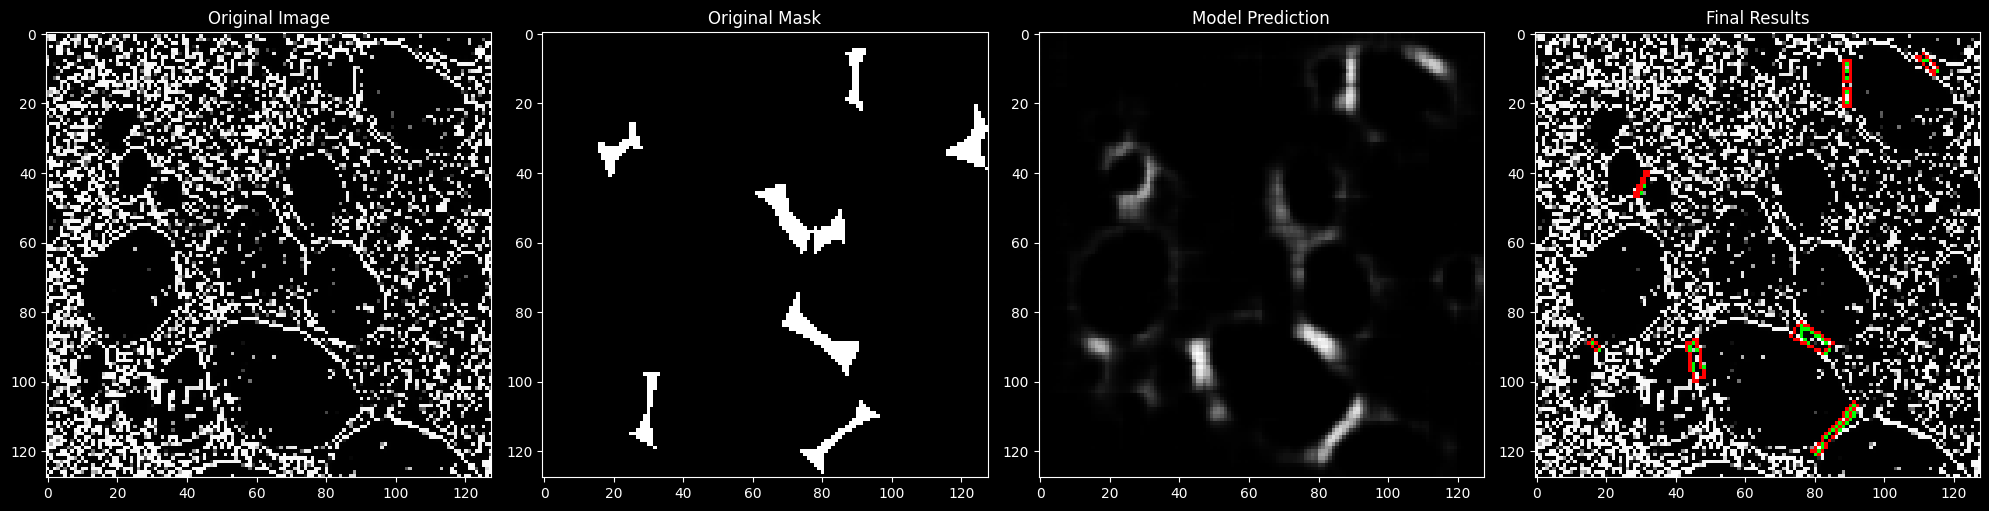

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


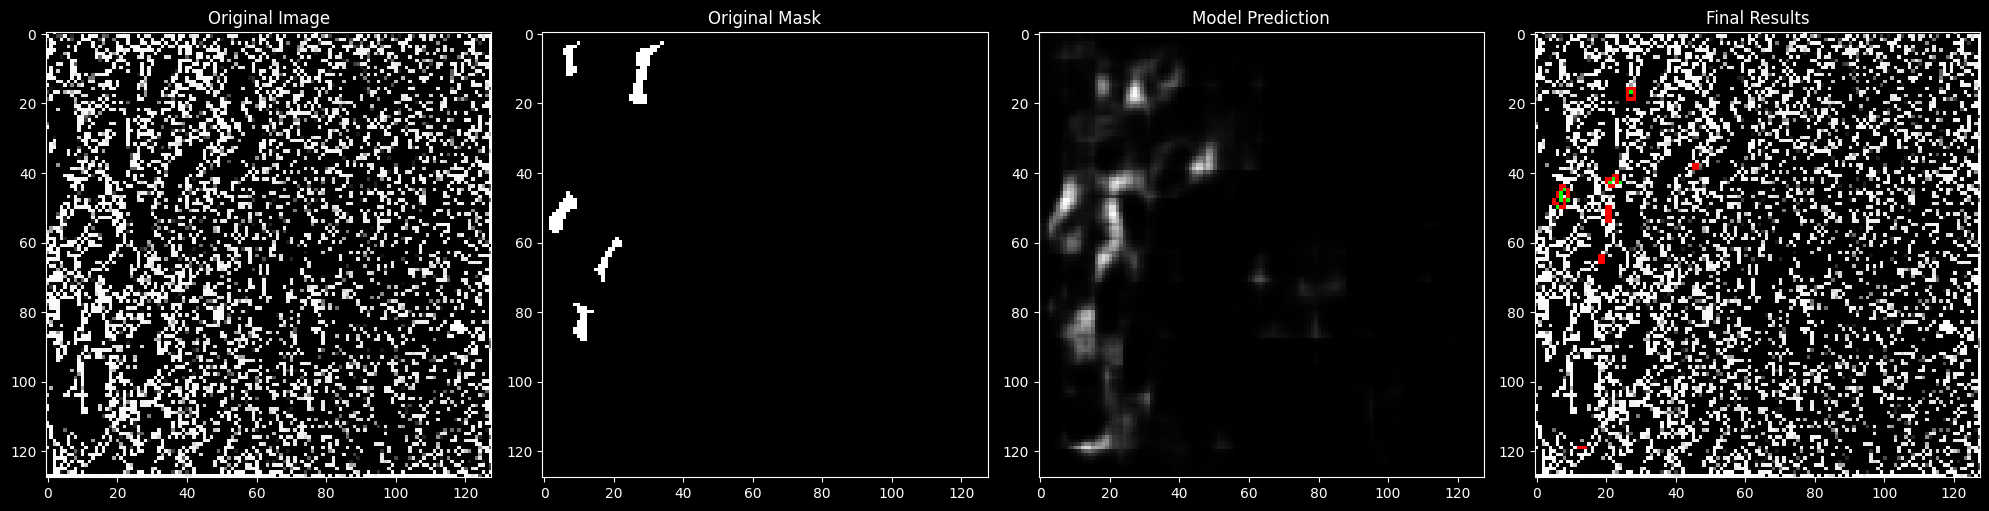

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


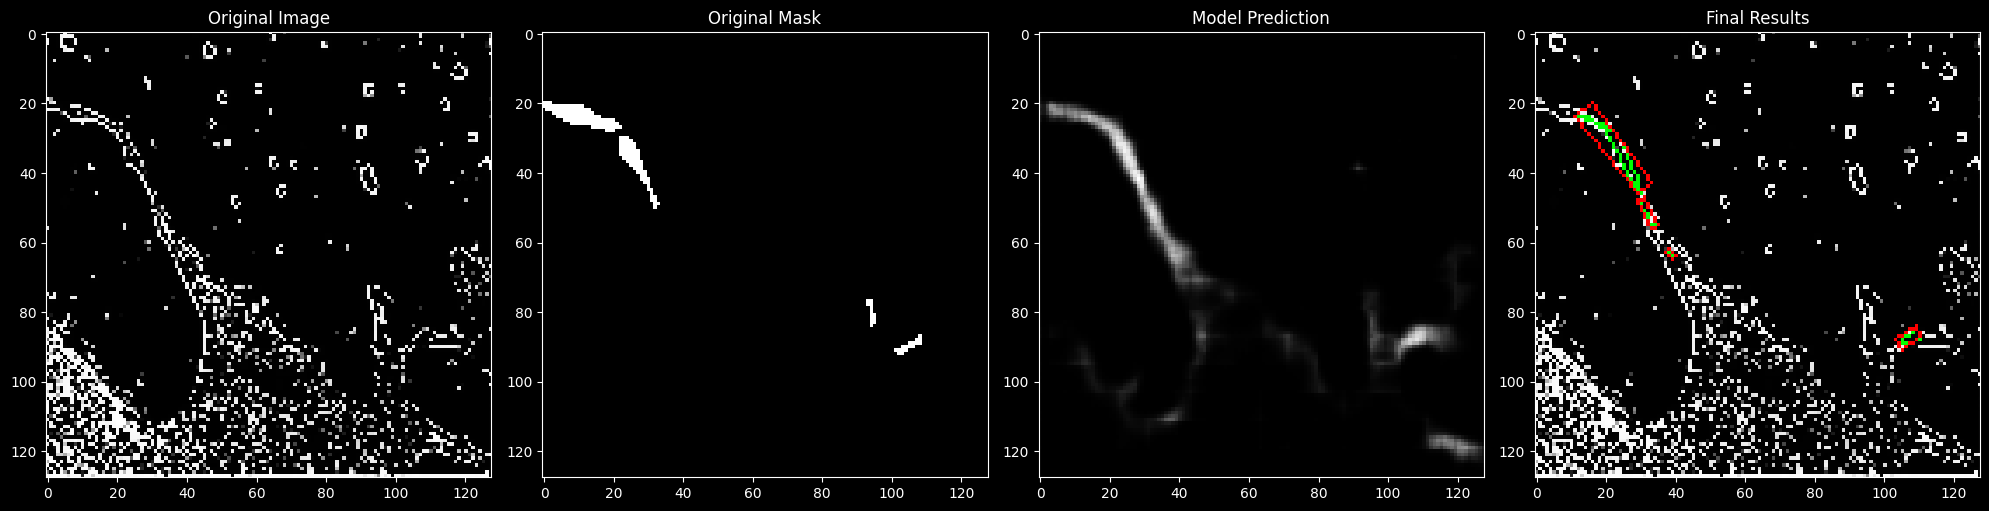

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


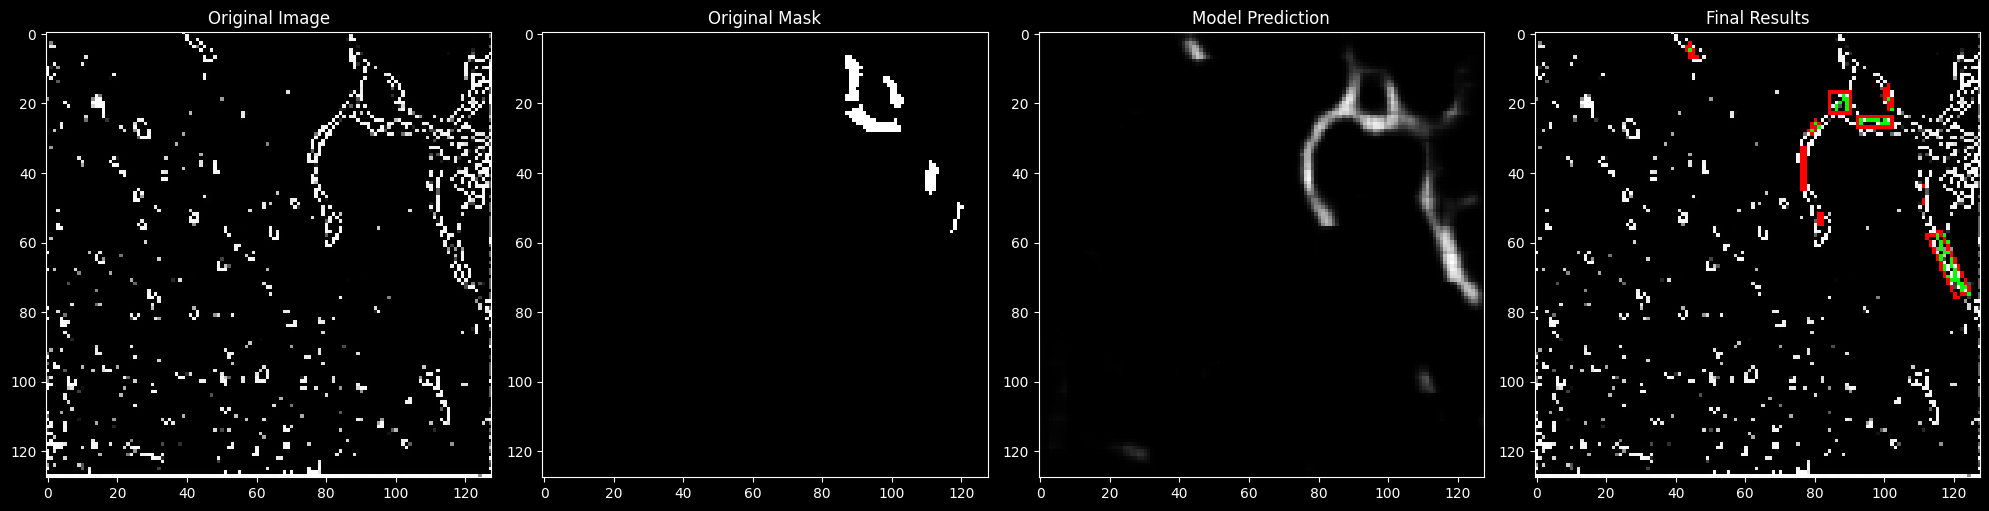

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


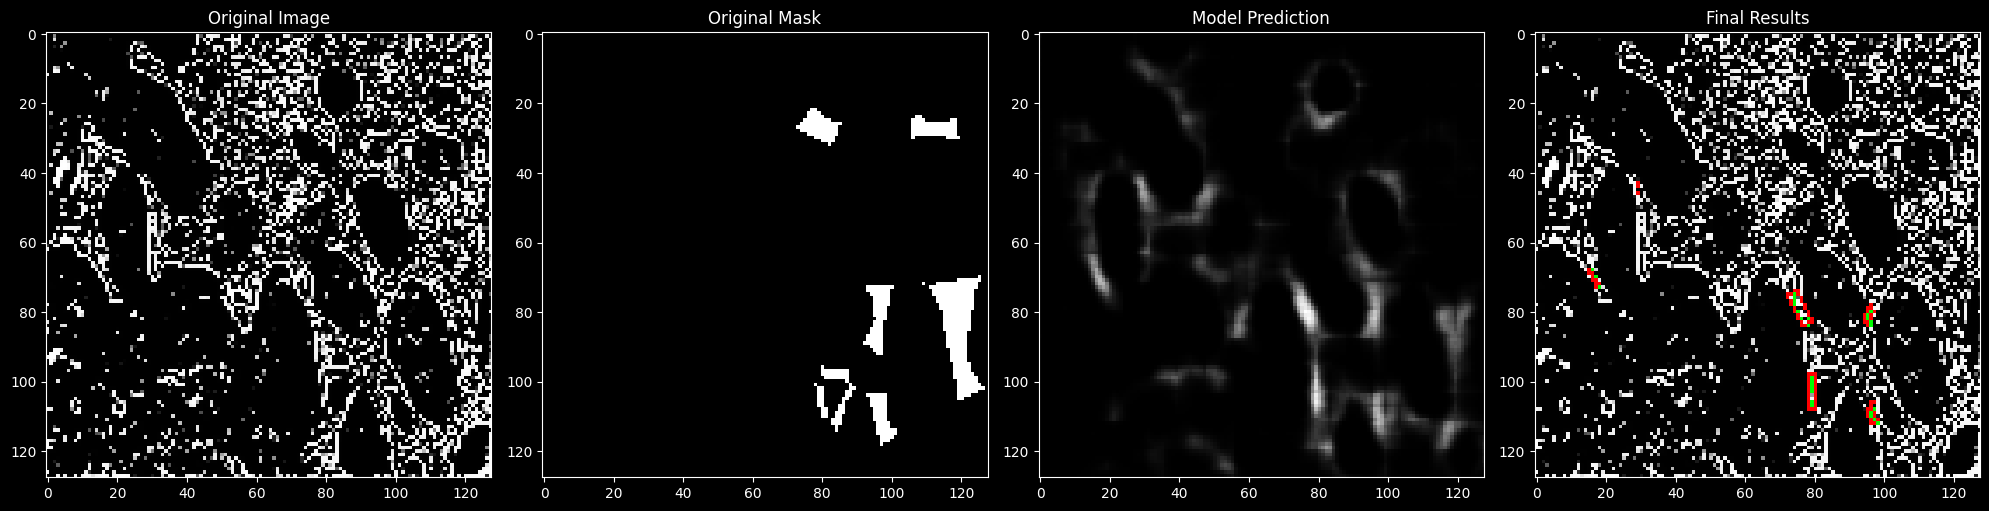

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


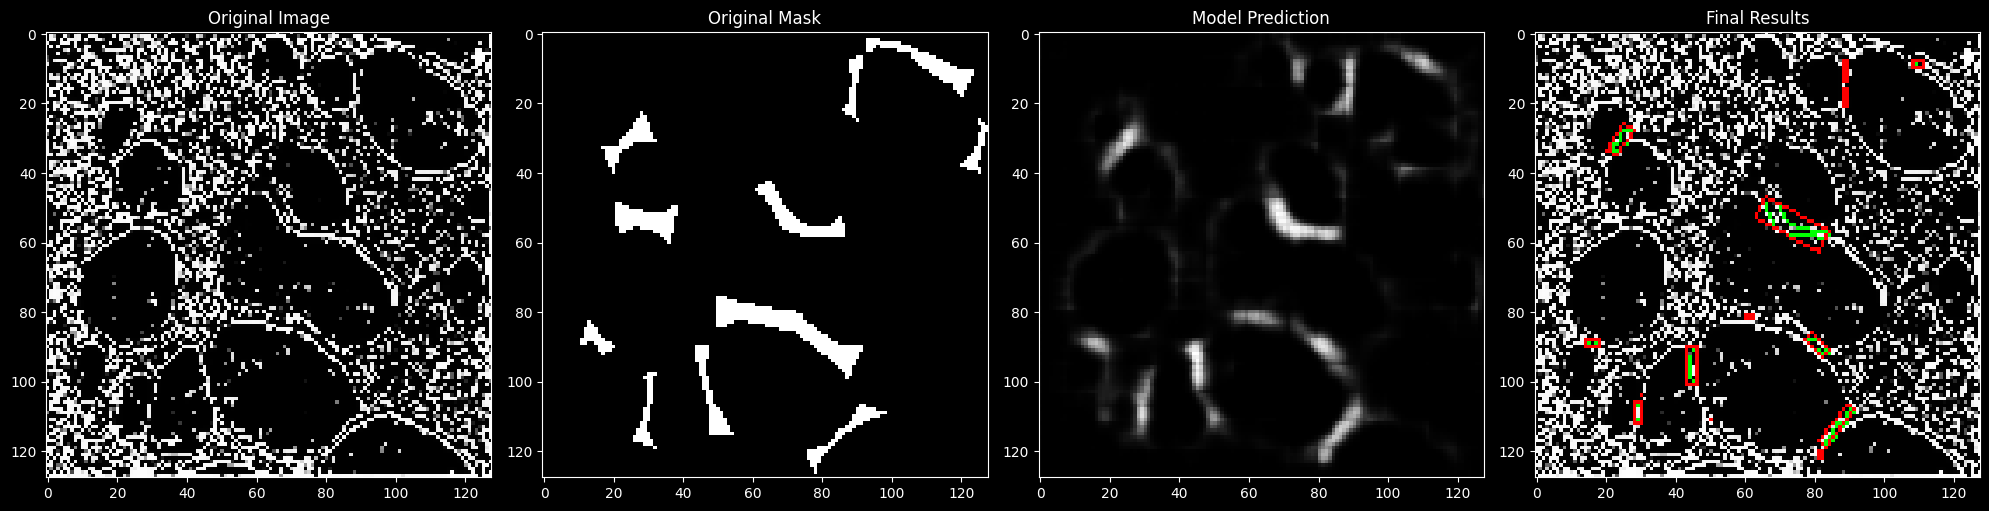

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


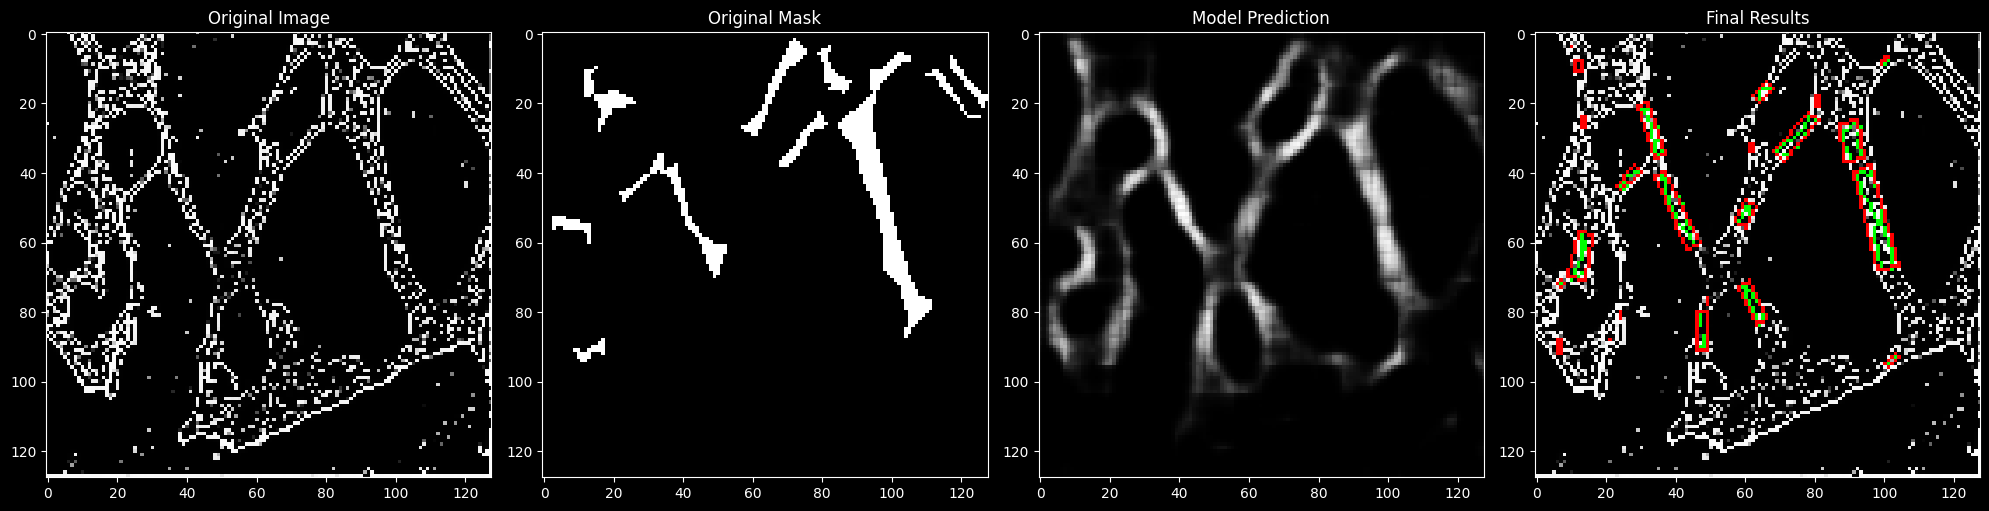

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


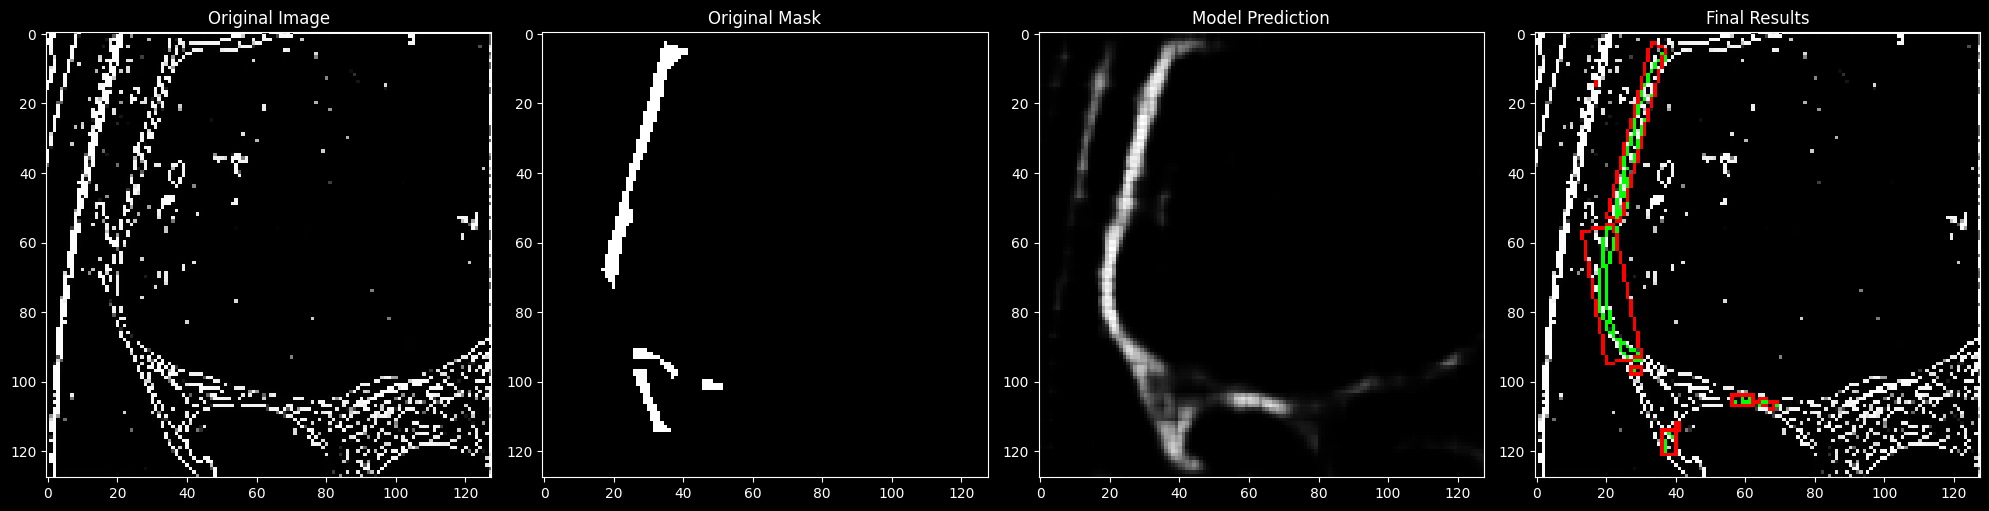

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


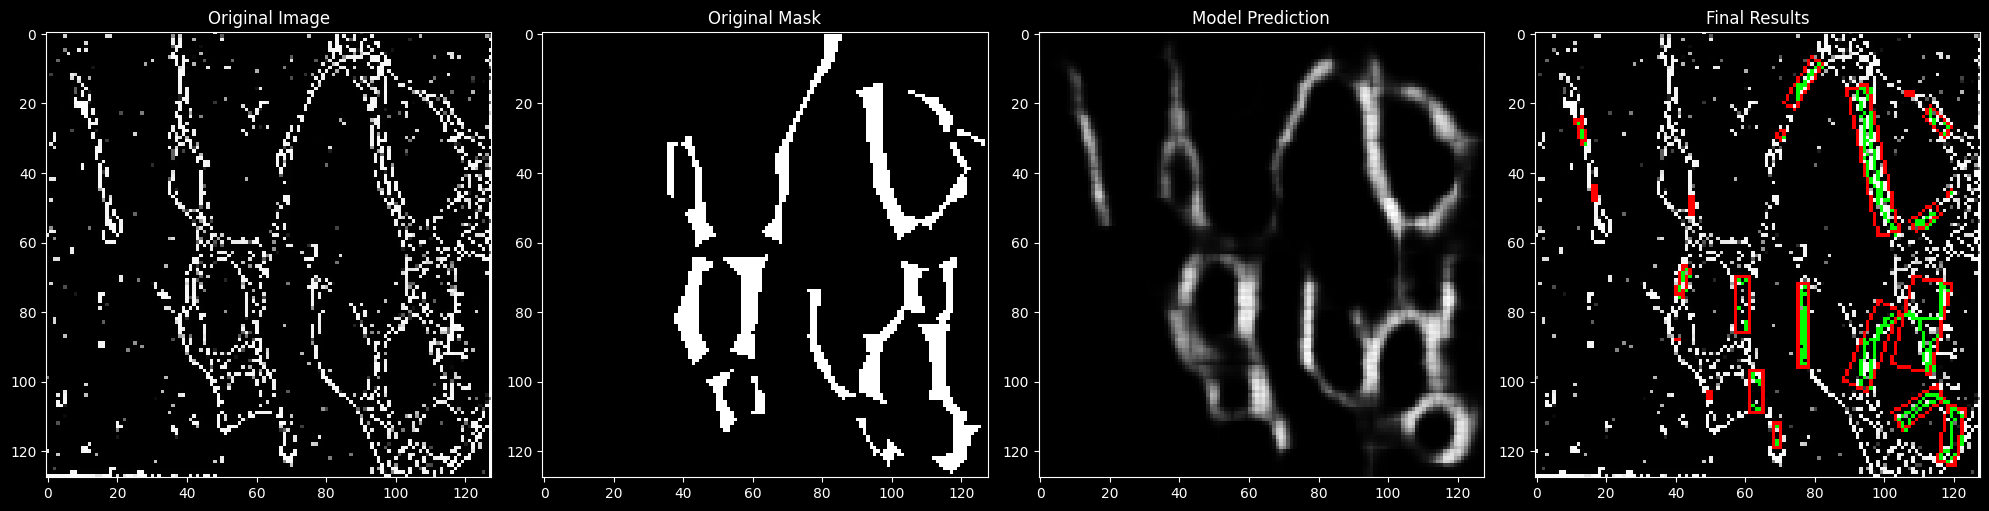

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


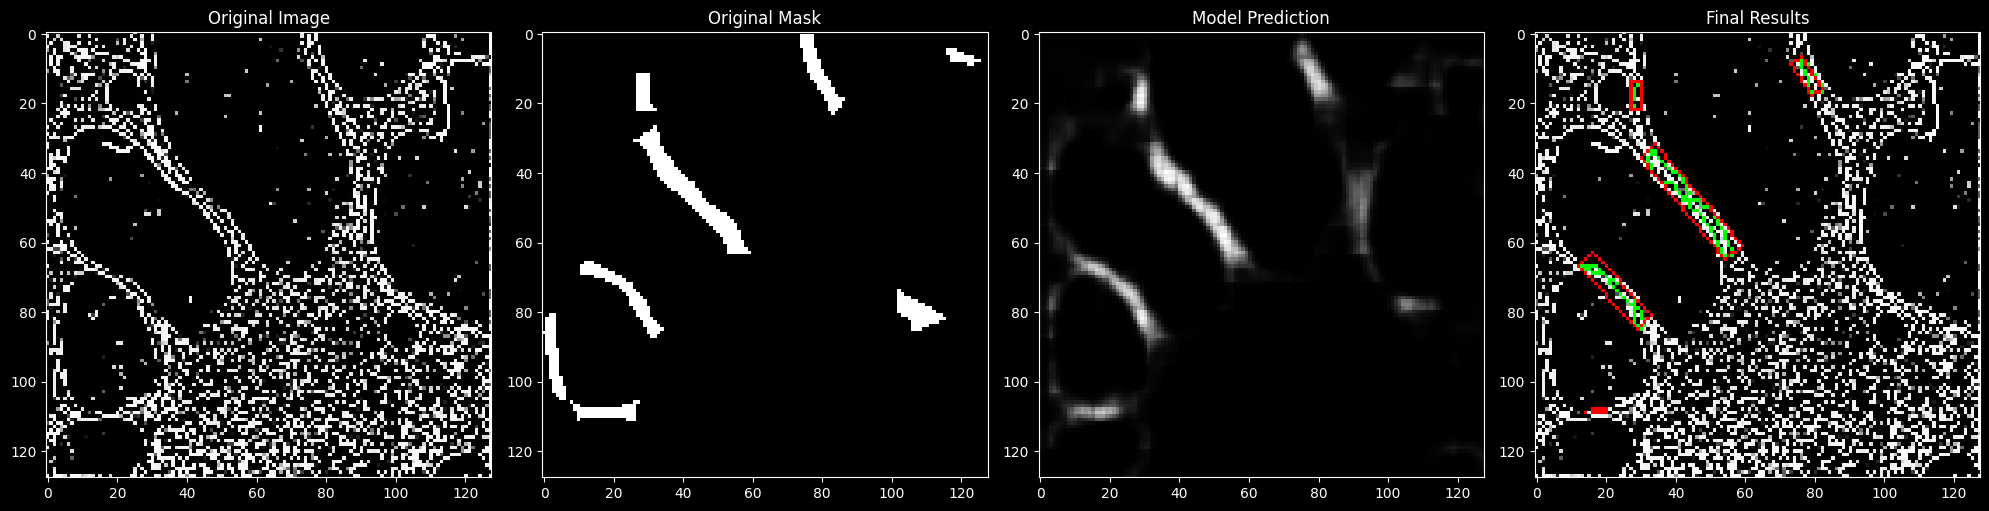

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


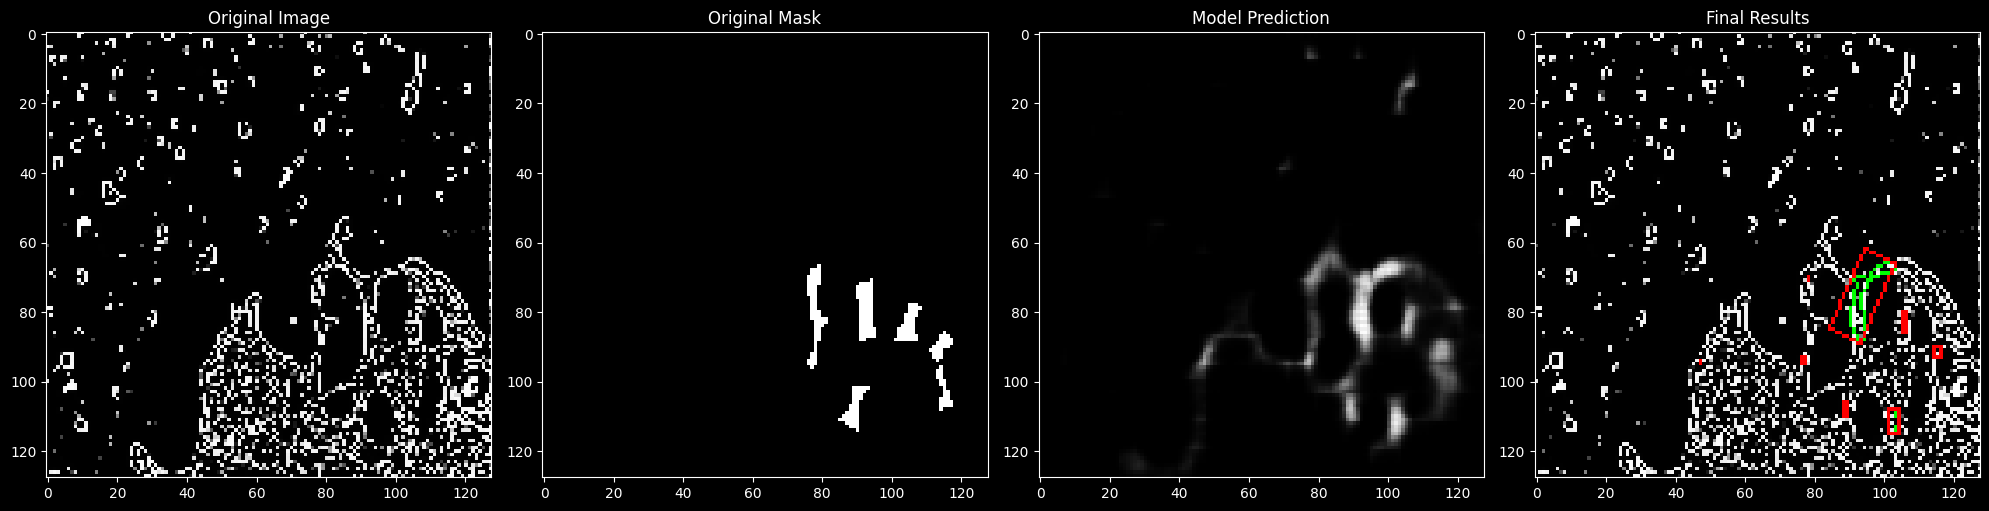

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para generar el Oriented Bounding Box (OBB)
def generar_obb(puntos):
    """
    Genera una Oriented Bounding Box (OBB) para un conjunto de puntos.

    Args:
        puntos (np.ndarray): Array de puntos que definen el polígono (Nx2).

    Returns:
        rect (cv2.RotatedRect): Rectángulo rotado que representa la OBB.
    """
    puntos = np.array(puntos)
    rect = cv2.minAreaRect(puntos)
    return rect

# Función para dibujar siluetas y OBB en una imagen
def dibujar_silueta_y_obb(imagen, contours):
    """
    Dibuja las siluetas y el Oriented Bounding Box (OBB) de los contornos en la imagen.

    Args:
        imagen (np.ndarray): Imagen donde se dibujarán los contornos y los OBB.
        contours (list): Lista de contornos detectados.
    """
    for contour in contours:
        # Dibuja la silueta (contorno)
        cv2.drawContours(imagen, [contour], -1, (0, 255, 0), 1)  # Color verde para siluetas

        # Genera el OBB
        rect = generar_obb(contour)

        # Obtiene las coordenadas del OBB
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        # Dibuja el OBB
        cv2.polylines(imagen, [box], isClosed=True, color=(255, 0, 0), thickness=1)  # Color rojo, grosor reducido

# Función principal para mostrar imagen, máscara y predicción con silueta y OBB
def muestraRealvsPredConSiluetaYOBB(index, threshold=0.5):
    plt.figure(figsize=(20,10))

    # IMAGEN ORIGINAL
    plt.subplot(1, 4, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")
    
    # MÁSCARA REAL
    plt.subplot(1, 4, 2)
    plt.imshow(y_val[index].squeeze(), cmap='gray')
    plt.title("Original Mask")
    
    # MÁSCARA PREDICHA
    mask_pred = predicciones[index].squeeze()
    plt.subplot(1, 4, 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("Model Prediction")
    
    # CONVERTIMOS LA MÁSCARA PREDICHA EN BINARIA
    mask_binaria = (mask_pred > threshold).astype(np.uint8)

    # DETECTAMOS LOS CONTORNOS
    contours, _ = cv2.findContours(mask_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # COPIAMOS LA IMAGEN ORIGINAL
    imagen_con_dibujos = X_val[index].copy()

    # DIBUJAMOS LAS SILUETAS Y LOS OBB
    dibujar_silueta_y_obb(imagen_con_dibujos, contours)

    # MOSTRAMOS LA IMAGEN RESULTANTE
    plt.subplot(1, 4, 4)
    plt.imshow(imagen_con_dibujos)
    plt.title("Final Results")
    
    plt.tight_layout()
    plt.show()

# MOSTRAMOS EJEMPLOS
for i in range(40):
    # img_random = np.random.randint(0, len(predicciones) - 1)
    muestraRealvsPredConSiluetaYOBB(i)